# Opis projektu i zbioru danych
W ramach projektu analizowany jest zbiór danych *World Happiness Report 2021* (Raport Szczęścia Świata 2021) dostępny na portalu Kaggle. Jest to zbiór dotyczący globalnych wyników szczęścia — czyli poziomu zadowolenia mieszkańców różnych krajów świata. Dane obejmują wyniki dla 149 krajów i zostały rozszerzone o informacje o regionach geograficznych.

Źródłem danych są coroczne raporty ONZ – *World Happiness Report*, przygotowywane we współpracy z instytutem **Gallupa** oraz **Sustainable Development Solutions Network**, oparte głównie na ankietach oceniających dobrostan i satysfakcję z życia w latach 2005–2020.

Główną analizowaną zmienną zależną jest **Life Ladder**, która określa poziom szczęścia mieszkańców danego kraju.

**Wybrane zmienne do analizy:**
* country – kraj
* region – region świata
* gdp_per_capita – PKB per capita (zamożność)
* social_support – poczucie wsparcia społecznego
* healthy_expectancy – spodziewana długość życia
* freedom – poczucie wolności
* generosity – poziom hojności
* corruption – postrzegana korupcja

Dodatkowo, analiza będzie dążyła do odpowiedzi na następujące pytania:
1. Które czynniki (np. PKB, wsparcie społeczne, długość życia) mają najsilniejszy związek z poziomem szczęścia?
2. Czy istnieją istotne różnice w poziomie szczęścia między regionami świata (np. Europa Zachodnia vs. Afryka Subsaharyjska)?
3. Czy najbogatsze kraje są rzeczywiście najszczęśliwsze? A może inne czynniki (np. wolność, brak korupcji) są równie istotne?
4. Które kraje odstają od trendów, czyli np. mają wysokie PKB i niski poziom szczęścia lub odwrotnie — dlaczego?

Celem projektu jest zbadanie zależności między poziomem szczęścia (Life Ladder), a czynnikami ekonomicznymi i społecznymi — z uwzględnieniem regionów i lat.

In [140]:
# Importy i wczytanie danych
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [141]:
# wykresy w notebooku oraz ich jakość
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [142]:
# wczytanie dataseta, dodanie regionów do df oraz zmiana nazwy kolumn i sprawdzenie czy jest wczytany poprawnie
df = pd.read_csv('../data/world-happiness-report.csv')

region_map = pd.read_csv("../data/country-region-mapping.csv")
region_map = region_map.drop_duplicates()


df = df.merge(region_map, on="Country name", how="left")

df.rename(columns={'Country name': 'country'}, inplace=True)
df.rename(columns={'Life Ladder': 'life_ladder'}, inplace=True)
df.rename(columns={'Log GDP per capita' : 'gdp_per_capita'}, inplace=True)
df.rename(columns={'Social support': 'social_support'}, inplace=True)
df.rename(columns={'Healthy life expectancy at birth': 'healthy_expectancy'}, inplace=True)
df.rename(columns={'Freedom to make life choices': 'freedom'}, inplace=True)
df.rename(columns={'Generosity': 'generosity'}, inplace=True)
df.rename(columns={'Perceptions of corruption': 'corruption'}, inplace=True)
df.rename(columns={'Positive affect': 'positive_affect'}, inplace=True)
df.rename(columns={'Negative affect': 'negative_affect'}, inplace=True)
df.rename(columns={'Region': 'region'}, inplace=True)

# usunięcie zbędnych kolumn
df.drop(columns=['positive_affect', 'negative_affect'], inplace=True)

df.head()

,country,year,life_ladder,gdp_per_capita,social_support,healthy_expectancy,freedom,generosity,corruption,region
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,South Asia
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,South Asia
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,South Asia
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,South Asia
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,South Asia


### Usunięcie kolumn positive_affect i negative_affect
W trakcie przygotowania danych do analizy podjęto decyzję o usunięciu kolumn positive_affect oraz negative_affect. Wskaźniki te mierzą emocjonalne doświadczenia respondentów (np. odczuwanie radości, stresu, gniewu) i mają charakter subiektywny oraz trudny do porównania między krajami i latami.

Dodatkowe powody usunięcia:

1. Nie są bezpośrednio związane z kluczowymi pytaniami badawczymi dotyczącymi czynników wpływających na poziom szczęścia (np. PKB, zdrowie, wolność),

2. Mogą być silnie skorelowane z innymi zmiennymi w zbiorze (np. ladder score),

3. Ich obecność mogłaby wprowadzać szum i utrudniać interpretację wyników statystycznych i wizualnych.

W związku z powyższym kolumny te zostały trwale usunięte z dalszej analizy.

# Sprawdzenie występowania Outlierów

In [143]:
# sprawdzenie ilosći outlierów w kolumnach numerycznych
# Wykorzystamy metodę IQR (Interquartile Range) do identyfikacji outlierów

# Wybieramy tylko kolumny numeryczne, pomijając 'year'
numeric_cols = df.select_dtypes(include=[np.number]).drop(columns=['year'], errors='ignore').columns

# Tworzymy listę słowników z informacjami o outlierach
outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_summary.append({
        'column': col,
        'outlier_count': outliers.shape[0],
        'total_rows': df[col].count(),
        'percent_outliers': round(100 * outliers.shape[0] / df[col].count(), 2),
        'min': df[col].min(),
        'max': df[col].max(),
        'mean': df[col].mean(),
        'median': df[col].median()
    })

# Tworzymy DataFrame z wynikami
outlier_df = pd.DataFrame(outlier_summary).sort_values('percent_outliers', ascending=False)
outlier_df

,column,outlier_count,total_rows,percent_outliers,min,max,mean,median
6,corruption,164,1839,8.92,0.035,0.983,0.747125,0.8020
2,social_support,43,1936,2.22,0.290,0.987,0.812552,0.8355
5,generosity,36,1860,1.94,-0.335,0.698,0.000103,-0.0255
3,healthy_expectancy,15,1894,0.79,32.300,77.100,63.359374,65.2000
4,freedom,10,1917,0.52,0.258,0.985,0.742558,0.7630
0,life_ladder,0,1949,0.00,2.375,8.019,5.466705,5.3860
1,gdp_per_capita,0,1913,0.00,6.635,11.648,9.368453,9.4600


## Analiza wartości odstających (outlierów)
W powyższej tabeli przedstawiono podsumowanie wartości odstających w każdej zmiennej ilościowej. Do ich wykrycia zastosowano klasyczną metodę IQR (Interquartile Range), gdzie za outliery uznaje się wartości poniżej Q1 - 1.5 * IQR lub powyżej Q3 + 1.5 * IQR.

Największy odsetek wartości odstających występuje w kolumnie corruption (ok. 9%), co może wynikać z dużych różnic percepcji korupcji pomiędzy regionami i latami. Niewielki, ale zauważalny odsetek outlierów dotyczy także zmiennych social_support oraz generosity. W pozostałych kolumnach odsetek wartości odstających nie przekracza 2%, co sugeruje względnie stabilny rozkład.

Dla każdej zmiennej podano również wartości minimalne, maksymalne, średnie oraz medianę, co ułatwia ocenę wpływu outlierów na strukturę danych. Kolejnym krokiem będzie analiza, czy wartości odstające są wynikiem błędów, czy reprezentują realne zjawiska — co pomoże zdecydować, czy i jak należy je modyfikować (np. usunąć, przekształcić, zostawić).

### Weryfikacja ujemnych wartości w zmiennej `generosity`

Początkowo zakładano, że ujemne wartości `generosity` są błędne. Po dokładniejszym przeanalizowaniu definicji zmiennej okazało się, że `generosity` jest resztą z regresji darowizn na PKB per capita. Oznacza to, że ujemne wartości są dopuszczalne i mają sens statystyczny – wskazują na niższą hojność, niż przewiduje model oparty na zamożności kraju.

W związku z tym **zrezygnowano z imputacji**, a ujemne wartości potraktowano jako integralną część zbioru danych.


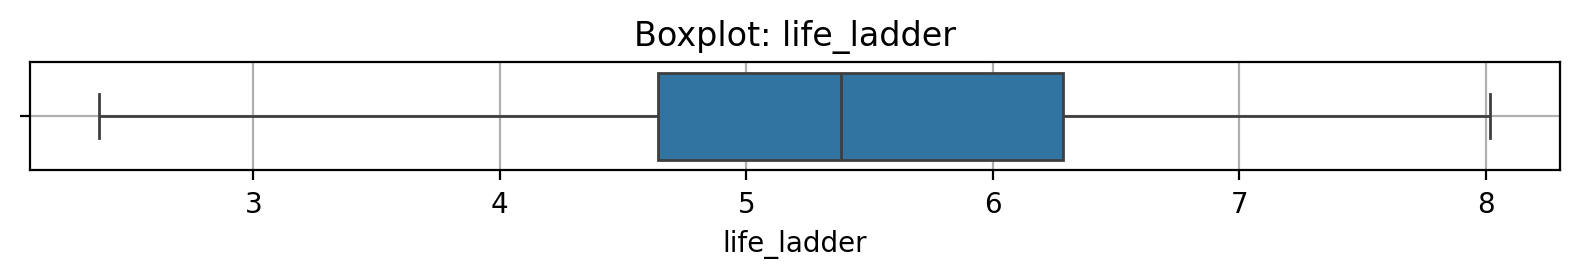

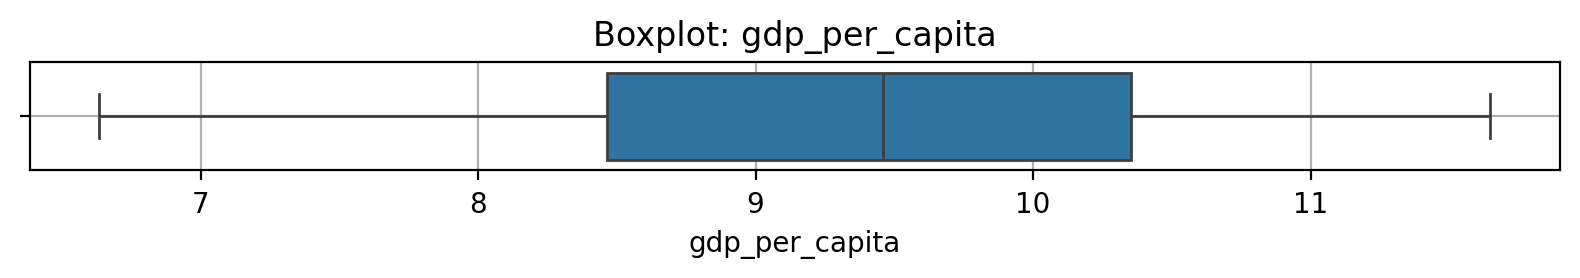

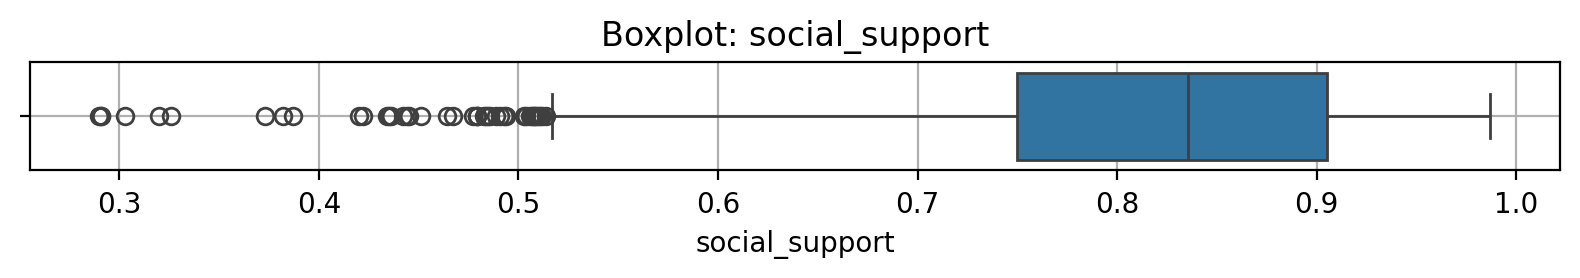

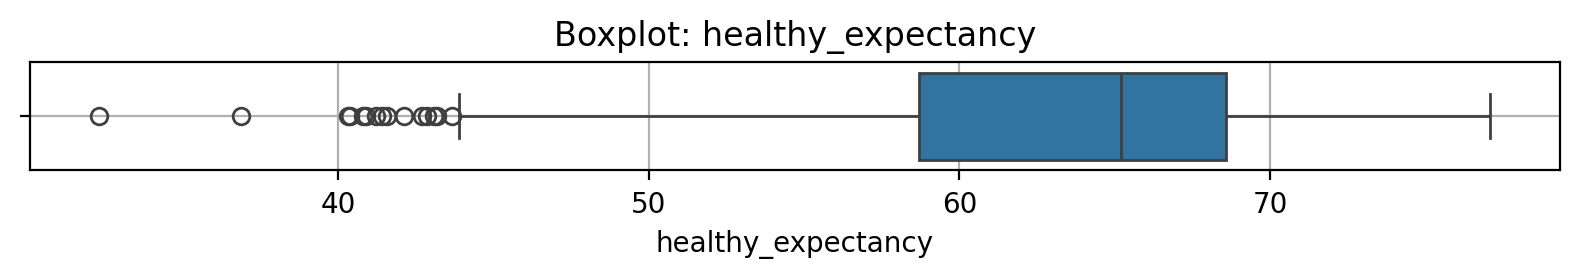

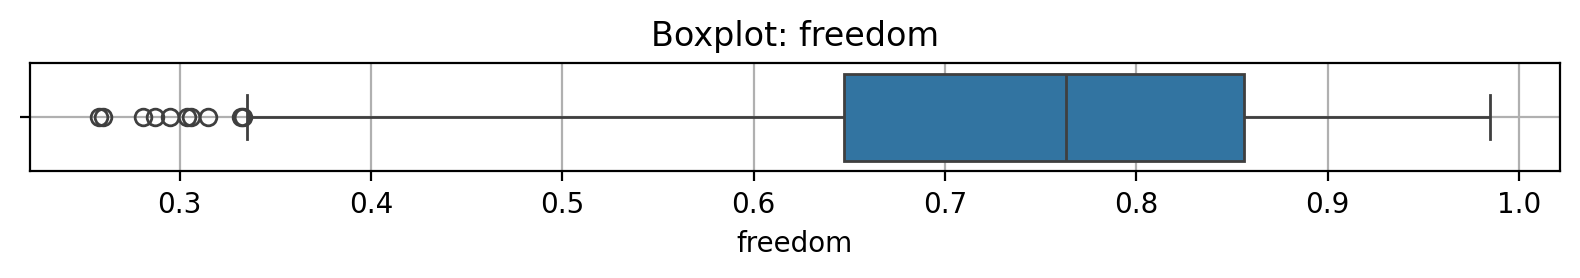

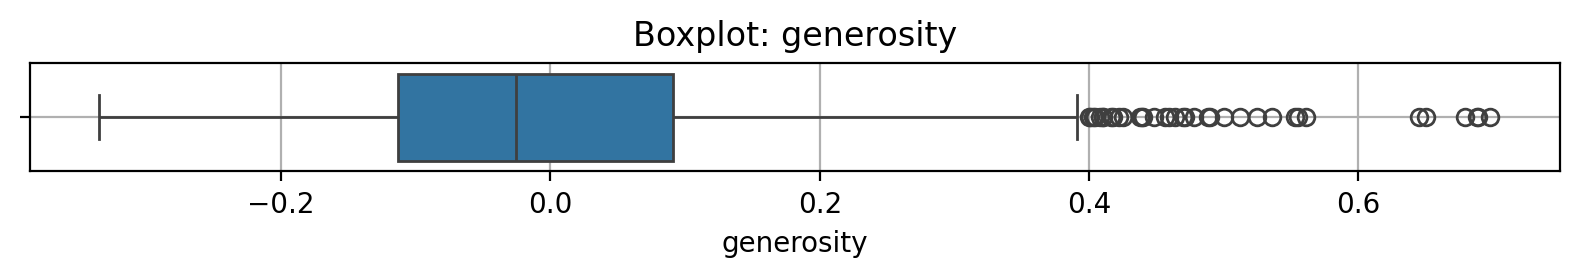

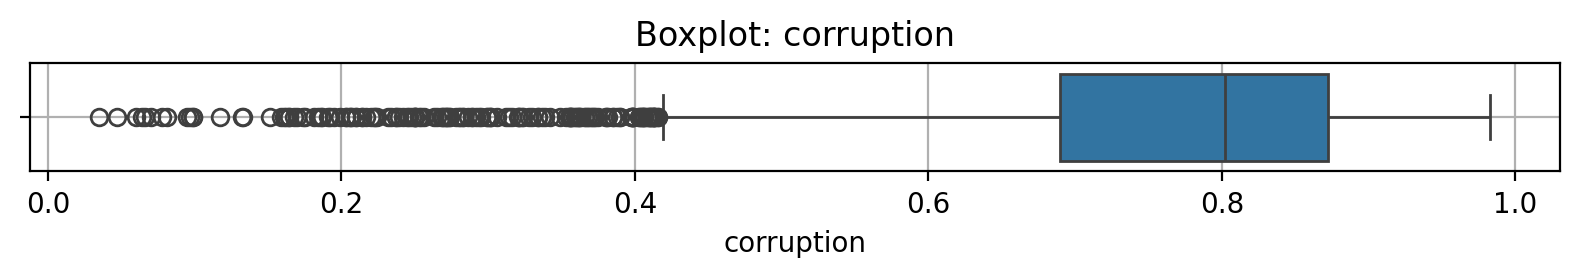

In [144]:
# Wybór kolumn numerycznych (bez 'year')
numeric_cols = df.select_dtypes(include=[np.number]).drop(columns=['year'], errors='ignore').columns

# Lista słowników z informacjami o outlierach
outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_summary.append({
        'column': col,
        'outlier_count': outliers.shape[0],
        'total_rows': df[col].count(),
        'percent_outliers': round(100 * outliers.shape[0] / df[col].count(), 2),
        'min': df[col].min(),
        'max': df[col].max(),
        'mean': df[col].mean(),
        'median': df[col].median(),
        'iqr': IQR
    })

# Tworzenie podsumowania
outlier_df = pd.DataFrame(outlier_summary).sort_values('percent_outliers', ascending=False)

# Wyświetlenie tabeli
# import ace_tools as tools; tools.display_dataframe_to_user(name="Podsumowanie wartości odstających", dataframe=outlier_df)

# Zapisanie wykresów boxplotów dla kolumn
for col in numeric_cols:
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot: {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Analiza wartości odstających (outlierów) w zmiennych ilościowych
W analizie skupiono się na zmiennych ilościowych obecnych w zbiorze danych. Kolumny positive_affect i negative_affect zostały wcześniej usunięte jako mniej istotne dla celów badania. Dla pozostałych kolumn sprawdzono rozkład wartości oraz występowanie obserwacji odstających (tzw. outlierów), bazując na klasycznym podejściu IQR (interkwartylowym).

1. ladder_score (wskaźnik szczęścia)

    Wartości mieszczą się w realistycznym zakresie (ok. 2–8).Outliery występują, ale są uzasadnione: kraje o bardzo wysokim lub bardzo niskim poziomie szczęścia.

2. gdp_per_capita

    Znaczący rozrzut, ale odzwierciedla rzeczywiste różnice gospodarcze pomiędzy krajami.

3. social_support

    Skrajne wartości pojawiają się rzadko i najczęściej dotyczą krajów o niskim poziomie zaufania społecznego.

4. healthy_expectancy

    Rozkład zbliżony do normalnego, outliery występują w krajach o bardzo niskiej oczekiwanej długości życia.

5. freedom

    Outliery reprezentują rzeczywiste różnice w wolności obywatelskiej w krajach autorytarnych.

6. generosity

    Największa liczba outlierów spośród wszystkich kolumn — ok. 9% obserwacji.Obecność wartości ujemnych nie musi oznaczać błędu — mogą pochodzić z regresji reszt.

7. corruption

    Wartości skrajne występują, ale są zgodne z oceną sytuacji politycznej na świecie.

Wszystkie zmienne zostały ocenione jako realistyczne i reprezentatywne. Outliery nie zostaną usunięte

# TODO pomyśleć czy w health_exp te dwa po 20 to jednak nie jest przesada

# Braki danych

In [145]:
# Sprawdzam ilość brakujących wartości w kolumnach
df_summary = pd.DataFrame({    
    "Null Count": df.isna().sum(),
    "Dtype": df.dtypes
}).sort_values("Null Count", ascending=False)
df_summary

,Null Count,Dtype
corruption,110,float64
generosity,89,float64
healthy_expectancy,55,float64
gdp_per_capita,36,float64
freedom,32,float64
social_support,13,float64
country,0,object
year,0,int64
life_ladder,0,float64
region,0,object


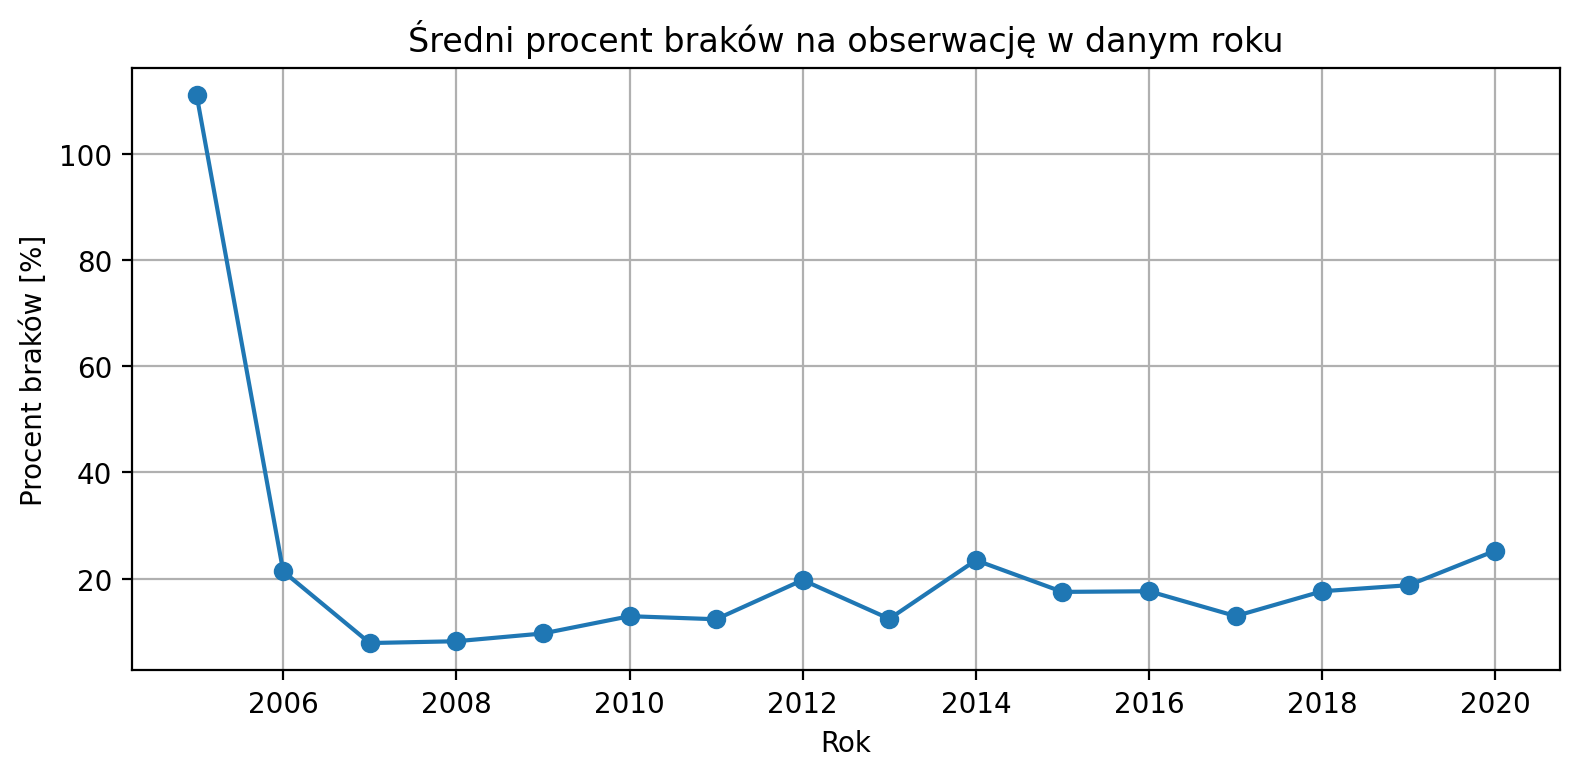

In [146]:
# Zliczenie liczby braków w każdej obserwacji
df['missing_per_row'] = df.isna().sum(axis=1)

# Obliczenie średniej liczby braków na obserwację w danym roku
mean_missing_by_year = df.groupby('year')['missing_per_row'].mean()

# Obliczenie procentu braków w danym roku
percent_missing_by_year = df.groupby('year')['missing_per_row'].sum() / df.groupby('year').size() * 100

# Połączenie do jednego DataFrame
missing_summary = pd.DataFrame({
    'avg_missing_per_row': mean_missing_by_year,
    'percent_missing': percent_missing_by_year
}).reset_index()

plt.figure(figsize=(8, 4))
plt.plot(missing_summary['year'], missing_summary['percent_missing'], marker='o')
plt.title('Średni procent braków na obserwację w danym roku')
plt.xlabel('Rok')
plt.ylabel('Procent braków [%]')
plt.grid(True)
plt.tight_layout()
plt.show()


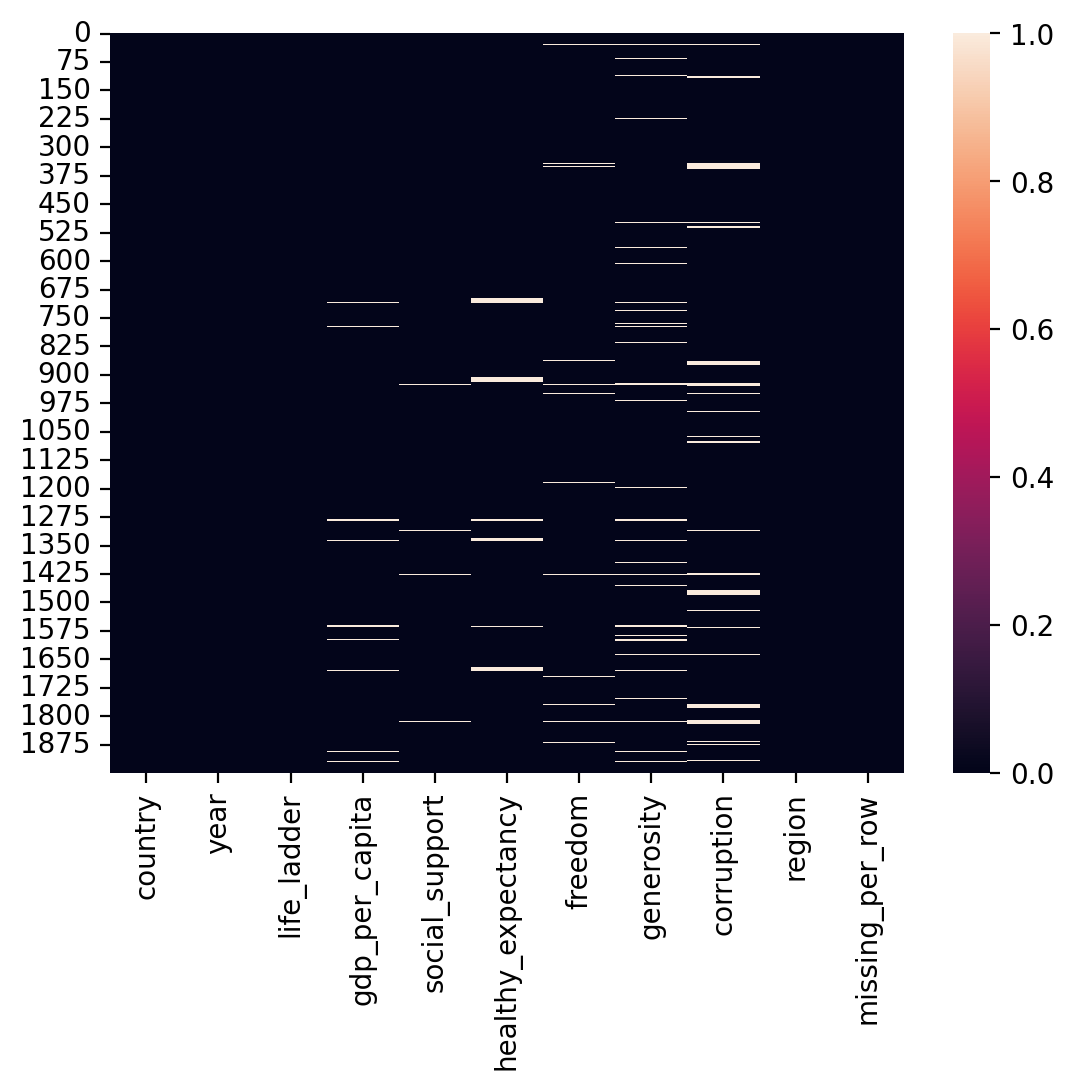

In [147]:
# sprawdzenie rozkładu braków w danych
sns.heatmap(df.isna());

In [148]:
# sprawdzam ile występuje obserwacji w obrębie regionów i lat
df.groupby(['region', 'year']).size().value_counts().sort_values(ascending=False)

2     27
8     14
5     13
7     10
1      9
29     9
20     8
19     8
21     7
17     6
4      6
15     5
10     3
6      3
35     3
18     3
26     3
3      3
16     3
9      2
36     2
22     2
28     2
23     2
11     2
25     1
32     1
34     1
14     1
13     1
Name: count, dtype: int64

## Analiza brakujących danych
Braki występują w 9 z 12 kolumn. Najwięcej braków zaobserwowano w kolumnie **corruption** (110), a także w **generosity**, **healthy_expectancy**, **gdp_per_capita** oraz **freedom**. Kolumny **country**, **year**, **life_ladder** oraz **region** są kompletne. Natomiast wykres prezentujący procentowy udział braków w danych w obrebie poszczególnych lat pokazuje, że rok 2005 znacznie odstaje odstaje pod względem kompletności danych. W 2005 roku na jedną obserwację przypadają średnio 1,18 braki. W pozostałych latach ilość ta nie przekracze 0,3. Z heatmapy prezentującej rozmieszczenie braków w danych można zauważyć, że braki nie są rozmieszczone równomiernie – ich skupiska pojawiają się w określonych obszarach (prawdopodobnie konkretnych latach lub regionach), co zostanie przeanalizowane w kolejnych krokach. Powyyższa tabela pokazuje, że w wielu regionach w poszczgólnych latach wystepuje bardzo mało obserwacji. W przypadku takich par region+rok imputacja braków będzie problematyczna.
<!-- Zauważono również, że w danych występują obserwacje z kilkoma pustymi wartościami w kolumnach. Zdecydowano o usunięciu takich, w których jest więcej niż 2, czyli dokładnie mniej niż 30 obserwacji. -->

<!-- TODO do edycji -->
W pierwszej kolejności poddano analizie kolumne 'corruption'.

In [149]:
# braki w 'corruption' wg. lat
df[df['corruption'].isnull()]['year'].value_counts()

year
2016    11
2015    10
2017    10
2012    10
2014     9
2019     8
2018     8
2011     8
2013     7
2020     6
2006     6
2010     5
2007     4
2008     3
2009     3
2005     2
Name: count, dtype: int64

In [150]:
# braki w 'corruption' wg regionów
df[df['corruption'].isnull()]['region'].value_counts()

region
Middle East and Northern Africa    64
East Asia                          15
Central and Eastern Europe         12
SouthEast Asia                      8
Western Europe                      6
Sub-Saharan Africa                  4
Latin America and Caribbean         1
Name: count, dtype: int64

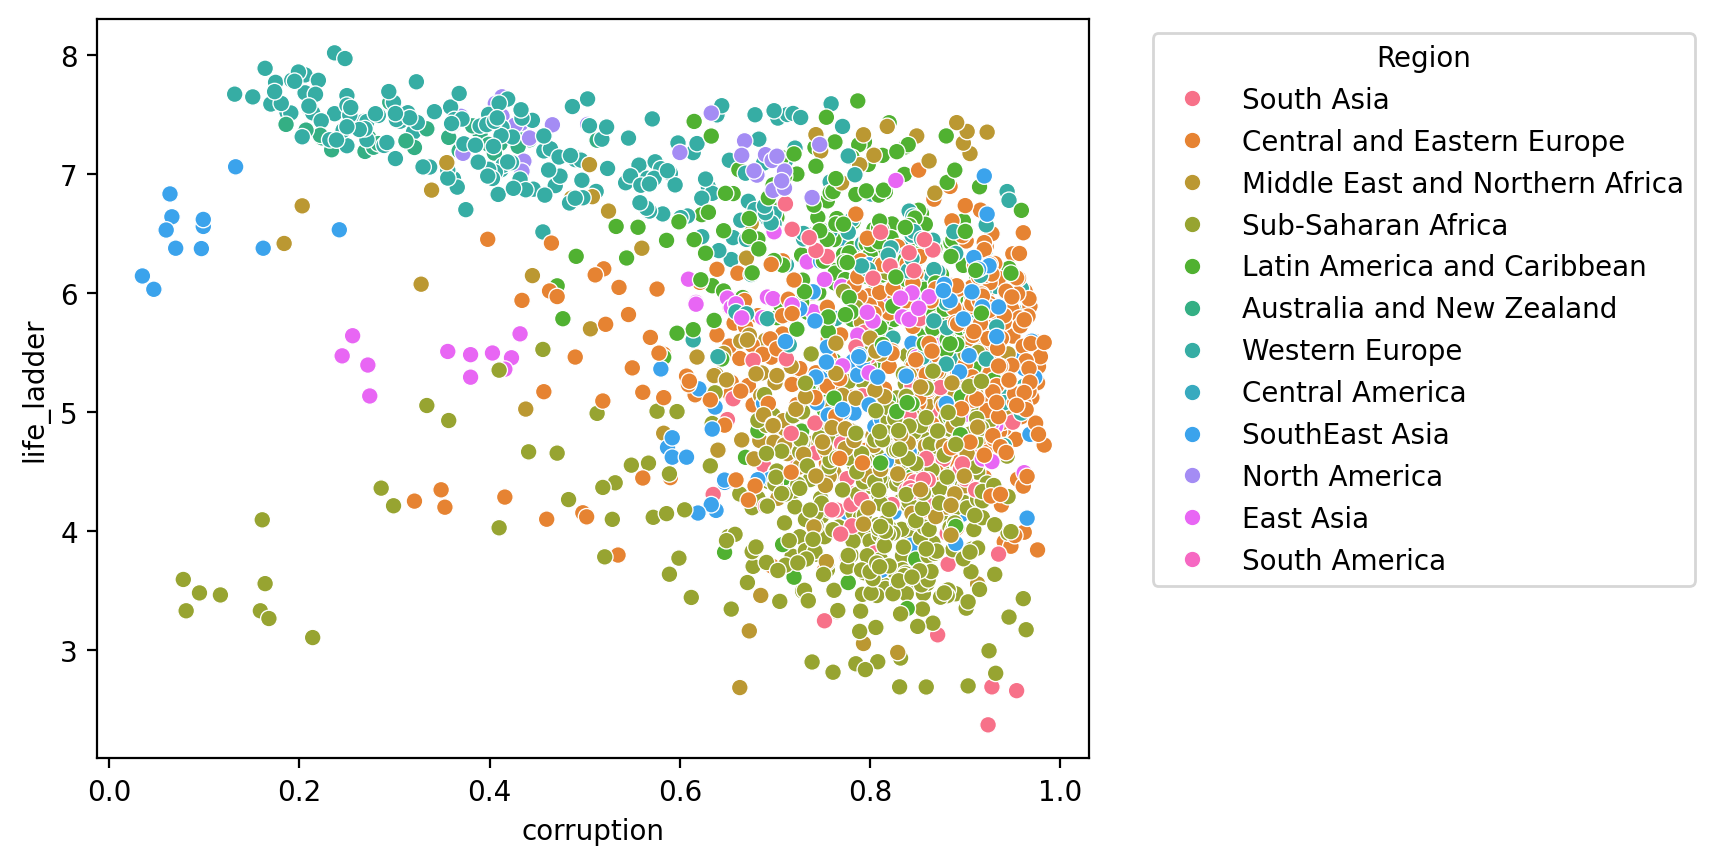

In [151]:
sns.scatterplot(data=df, x='corruption', y='life_ladder', hue='region')
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')


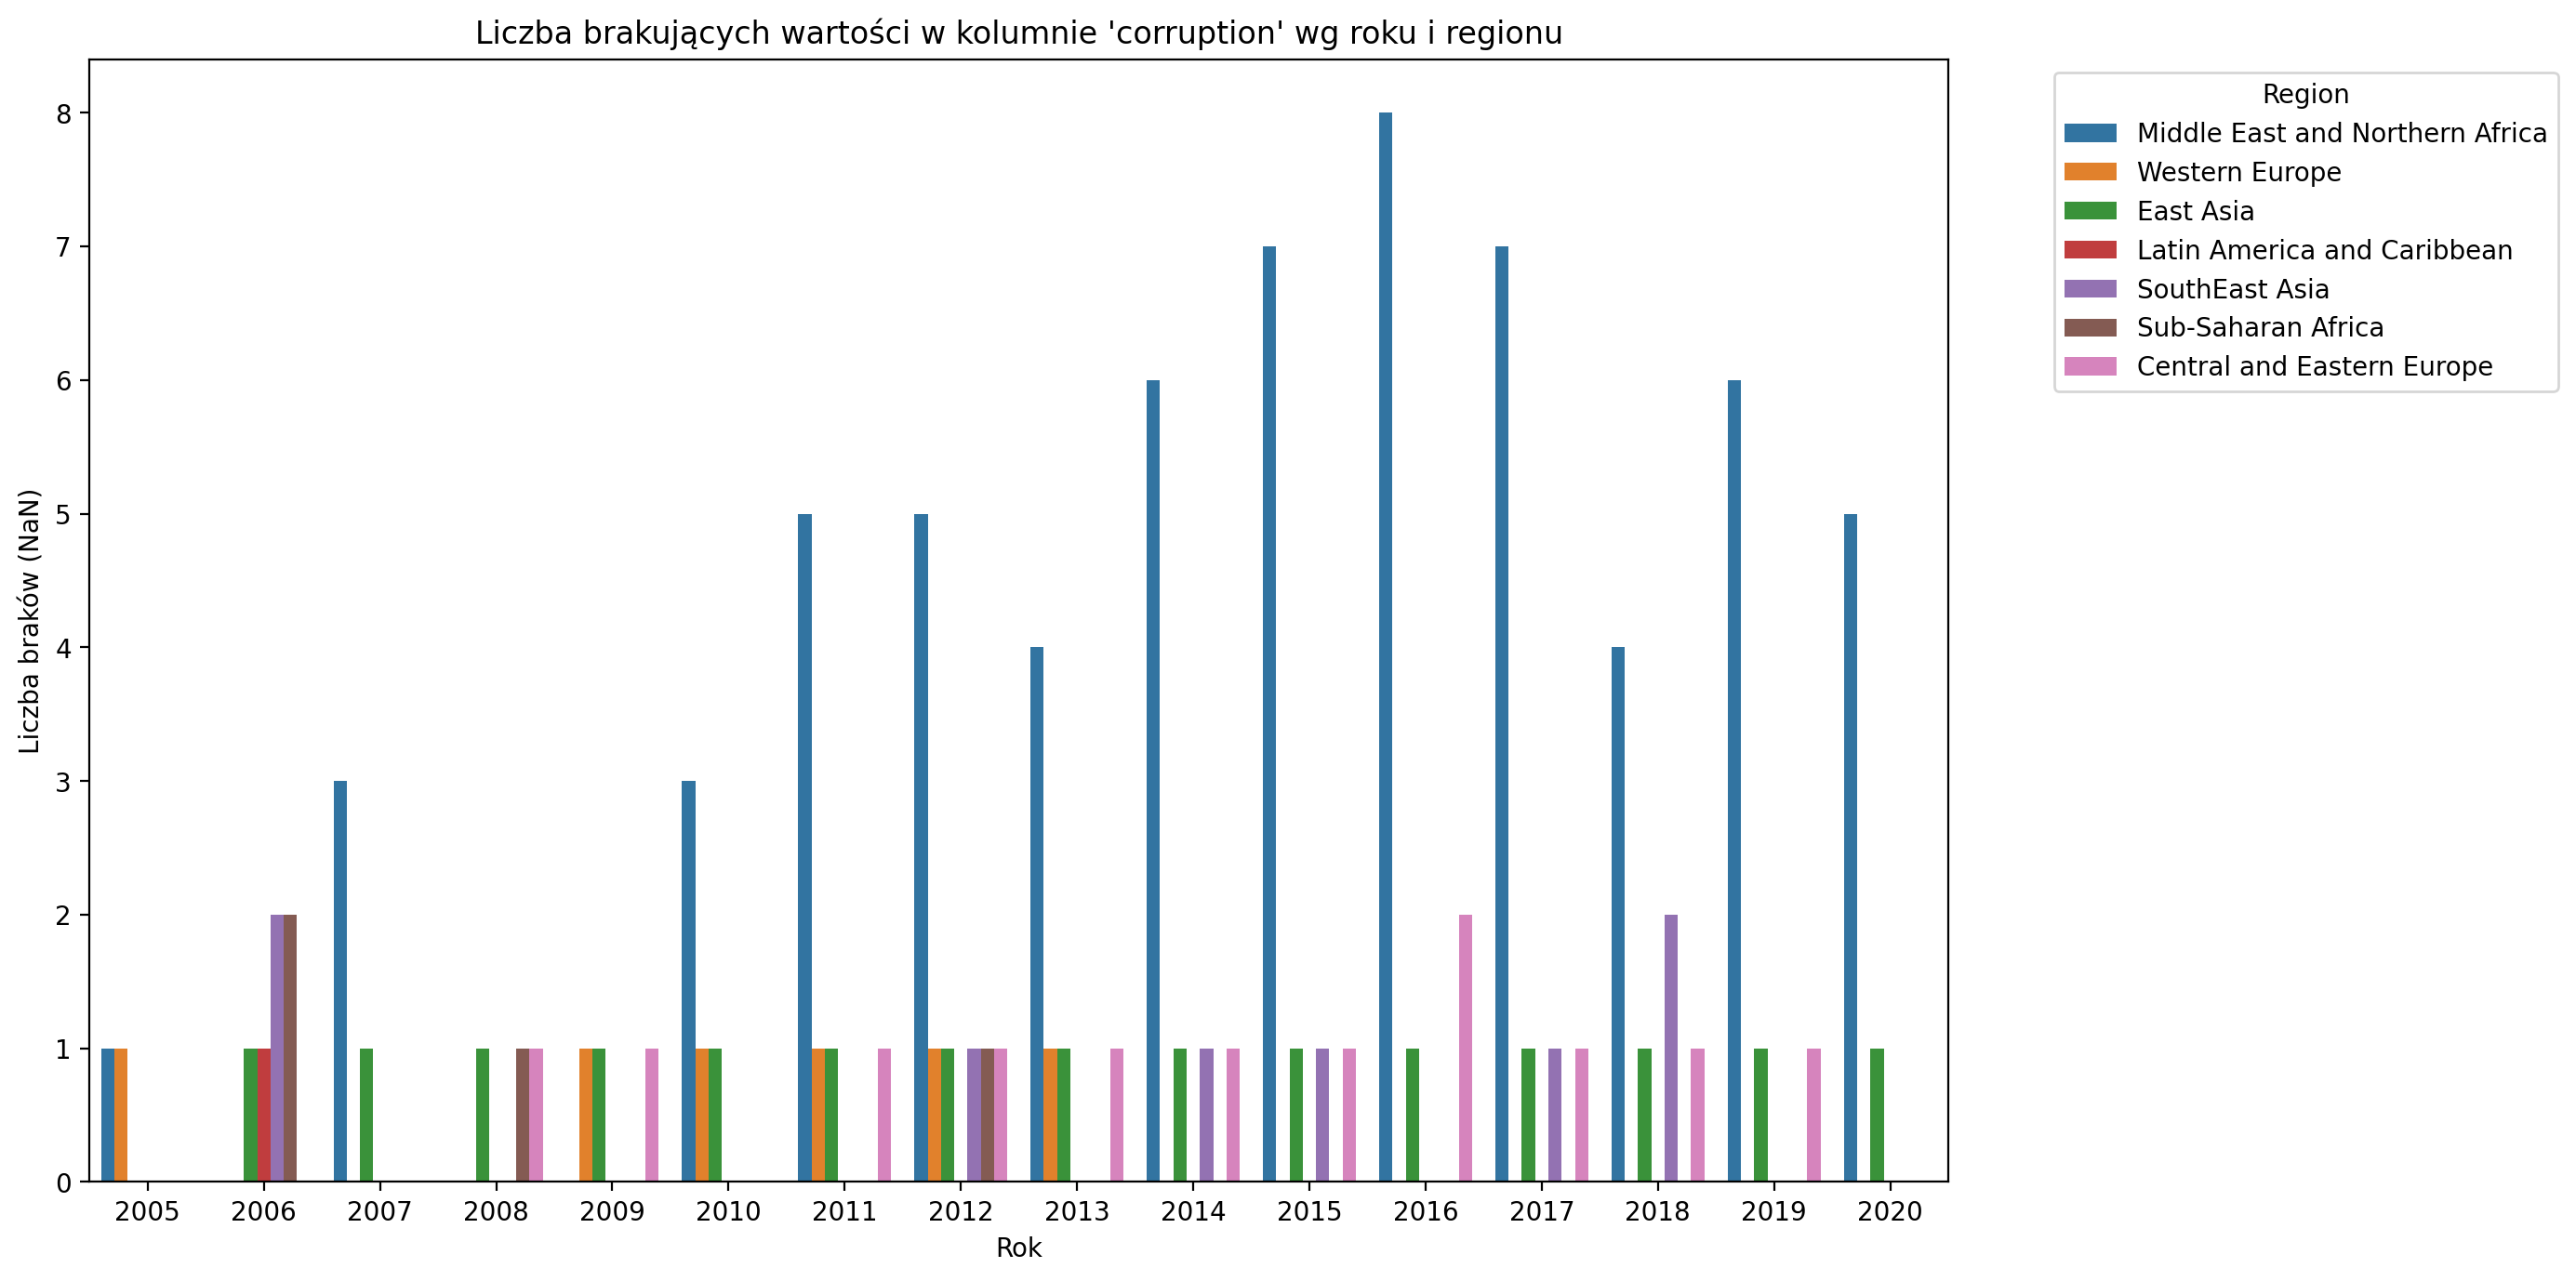

In [152]:
# Filtrowanie tylko obserwacji z brakującą wartością w 'corruption'
missing_corr = df[df['corruption'].isnull()]

# Grupowanie i zliczanie braków według roku i regionu
missing_corr_counts = missing_corr.groupby(['year', 'region']).size().reset_index(name='NaN_count')

# Tworzenie wykresu
plt.figure(figsize=(14, 7))
sns.barplot(data=missing_corr_counts, x='year', y='NaN_count', hue='region')
plt.title("Liczba brakujących wartości w kolumnie 'corruption' wg roku i regionu")
plt.xlabel("Rok")
plt.ylabel("Liczba braków (NaN)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<!-- TODO do edycji - może wyglądać lepiej -->
Braki danych w kolumnie 'corruption' rozkładają się w miarę równomiernie w latach, w których wystepuje najwięcej braków. Natomiast zdecydowanie najwięcej NaN wystepuje w regionie Middle East and Northern Africa. Mamy do czynienia z MAR (*Missing at random*). Wystapienie błedu zależy od regionu kraju. Postawowiono uzupełnić wartości medianą w każdego z regionów. Lata nie będą brały udziału w imputacji, ponieważ były by sytuacje, gdy mediana byłaby liczona czasem z niewielkiej liczby obserwacji.

In [153]:
# imputacja NaN w kolumnie 'corruption' medianą z regionów
df['corruption'] = df.groupby(['region'])['corruption'].transform(
    lambda x: x.fillna(x.median())
)
df['corruption'].isnull().sum()

0

<!-- TODO do edycji -->
Kolejno poddano analizie braki w kolumnie *freedom*

In [154]:
# braki w 'freedom' wg. lat
df[df['freedom'].isnull()]['year'].value_counts().sort_values(ascending=False)


year
2014    7
2006    3
2015    3
2008    3
2016    2
2005    2
2010    2
2009    2
2007    1
2013    1
2012    1
2018    1
2019    1
2020    1
2011    1
2017    1
Name: count, dtype: int64

In [155]:
# braki w 'freedom' wg. regionów
df[df['freedom'].isnull()]['region'].value_counts().sort_values(ascending=False)

region
Middle East and Northern Africa    12
Central and Eastern Europe          8
SouthEast Asia                      6
East Asia                           5
Sub-Saharan Africa                  1
Name: count, dtype: int64

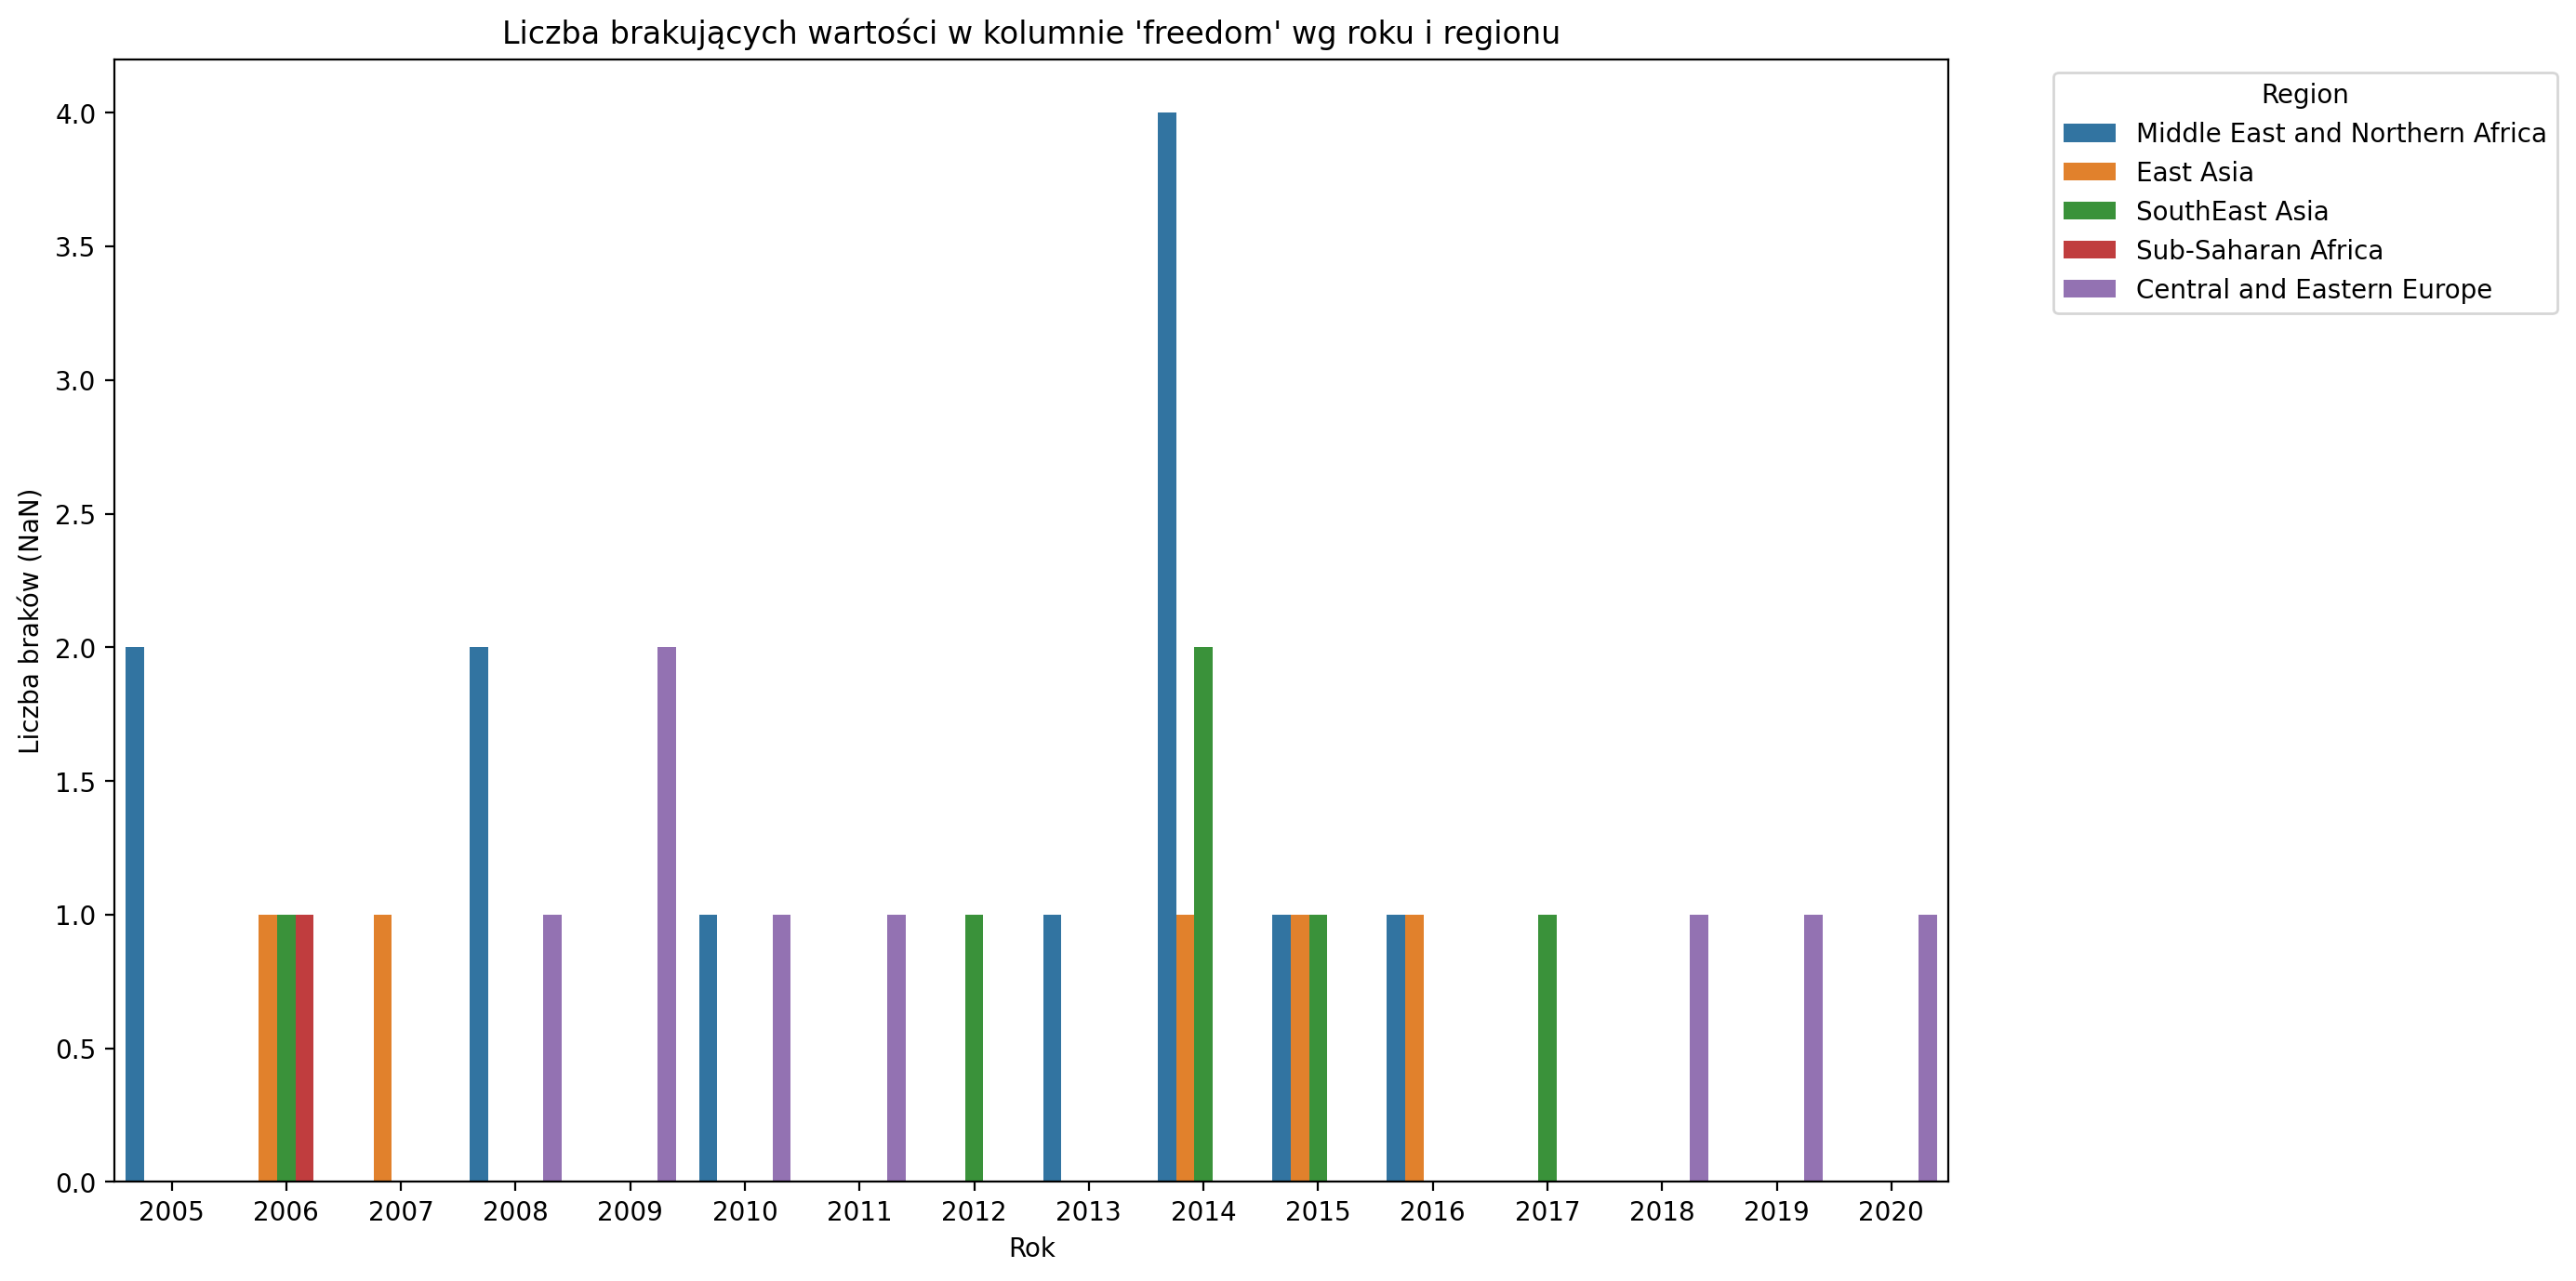

In [156]:
# Filtrowanie tylko obserwacji z brakującą wartością w 'freedom'
missing_gen = df[df['freedom'].isnull()]

# Grupowanie i zliczanie braków według roku i regionu
missing_gen_counts = missing_gen.groupby(['year', 'region']).size().reset_index(name='NaN_count')

# Tworzenie wykresu
plt.figure(figsize=(14, 7))
sns.barplot(data=missing_gen_counts, x='year', y='NaN_count', hue='region')
plt.title("Liczba brakujących wartości w kolumnie 'freedom' wg roku i regionu")
plt.xlabel("Rok")
plt.ylabel("Liczba braków (NaN)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<!-- TODO  przez przypadek 2x generosity zrobione. to trzeba przerobic na freedom Do edycji to i wszystkie markdowny poza jednym w sumie zrobionym porządnie -->
Kolumna *generosity* zawierała najwięcej braków w regionach *Middle East and Northern Africa* oraz *Western Europe*,. Równomiernie w latach -> zdecydowano się na imputację medianą w obrębie regionu. 

In [157]:
# imputacja NaN w kolumnie 'freedom' medianą z regionów
df['freedom'] = df.groupby(['region'])['freedom'].transform(
    lambda x: x.fillna(x.median())
)
df['freedom'].isnull().sum()

0

<!-- TODO do edycji -->
Kolejno poddano analizie braki w kolumnie *healthy_expectancy*

In [158]:
# braki w 'healthy_expectancy' wg. lat
df[df['healthy_expectancy'].isnull()]['year'].value_counts().sort_values(ascending=False)

year
2012    6
2011    5
2014    5
2016    5
2019    5
2017    4
2013    4
2015    4
2018    4
2009    3
2010    3
2020    3
2008    2
2006    1
2007    1
Name: count, dtype: int64

In [159]:
# braki w 'healthy_expectancy' wg. regionów
df[df['healthy_expectancy'].isnull()]['region'].value_counts().sort_values(ascending=False)

region
Central and Eastern Europe         14
East Asia                          11
South Asia                         10
Middle East and Northern Africa     9
Western Europe                      7
Sub-Saharan Africa                  4
Name: count, dtype: int64

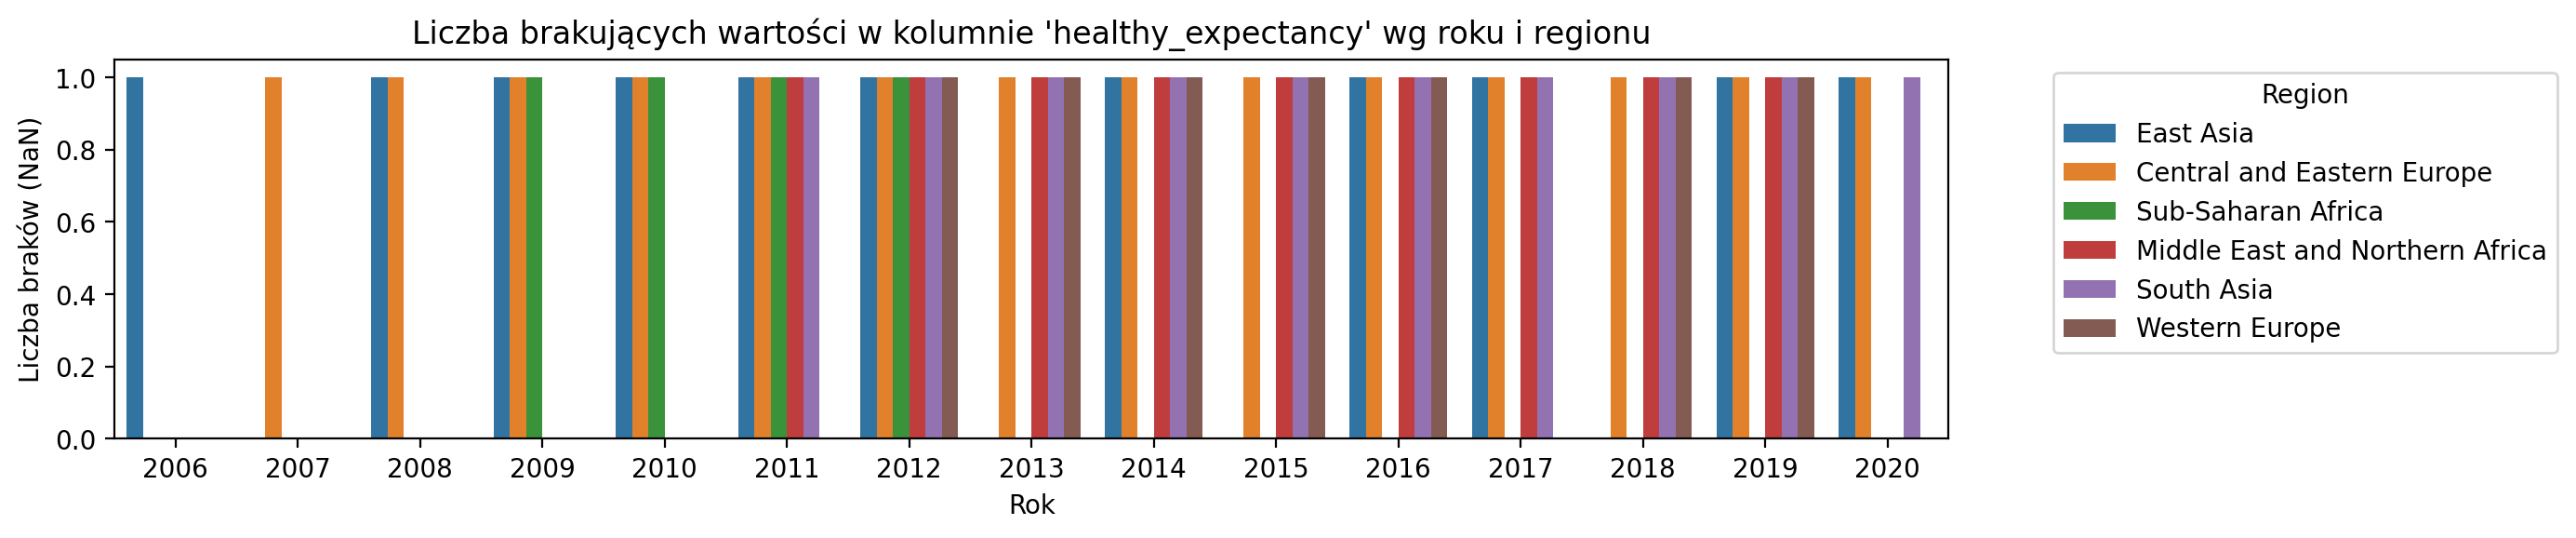

In [160]:
# Filtrowanie tylko obserwacji z brakującą wartością w 'generosity'
missing_health = df[df['healthy_expectancy'].isnull()]

# Grupowanie i zliczanie braków według roku i regionu
missing_health_counts = missing_health.groupby(['year', 'region']).size().reset_index(name='NaN_count')

# Tworzenie wykresu
plt.figure(figsize=(14, 3))
sns.barplot(data=missing_health_counts, x='year', y='NaN_count', hue='region')
plt.title("Liczba brakujących wartości w kolumnie 'healthy_expectancy' wg roku i regionu")
plt.xlabel("Rok")
plt.ylabel("Liczba braków (NaN)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<!-- TODO do edycji -->
Kolumna *healthy_expectancy* zawierała braki w regionach *Middle East and Northern Africa*, *Central and Eastern Europe*, *East Asia* oraz *Southern Asia*. Żaden z poszczególnych roków nie wybija się ponad inne w ilości braków. Zdecydowano się na imputację medianą w obrębie regionu. 

In [161]:
# imputacja NaN w kolumnie 'healthy_expectancy' medianą z regionów
df['healthy_expectancy'] = df.groupby(['region'])['healthy_expectancy'].transform(
    lambda x: x.fillna(x.median())
)
df['healthy_expectancy'].isnull().sum()

0

<!-- TODO do edycji -->
Kolejno poddano analizie braki w kolumnie *generosity*

In [162]:
# braki w 'generosity' wg. lat
df[df['generosity'].isnull()]['year'].value_counts().sort_values(ascending=False)

year
2005    26
2012     9
2006     8
2014     7
2020     7
2019     7
2018     6
2016     4
2013     4
2015     4
2011     2
2017     2
2008     1
2009     1
2010     1
Name: count, dtype: int64

In [163]:
# braki w 'generosity' wg. regionów
df[df['generosity'].isnull()]['region'].value_counts().sort_values(ascending=False)

region
Middle East and Northern Africa    29
Western Europe                     21
Sub-Saharan Africa                 12
Latin America and Caribbean         8
South Asia                          6
East Asia                           5
Central and Eastern Europe          5
Australia and New Zealand           1
North America                       1
SouthEast Asia                      1
Name: count, dtype: int64

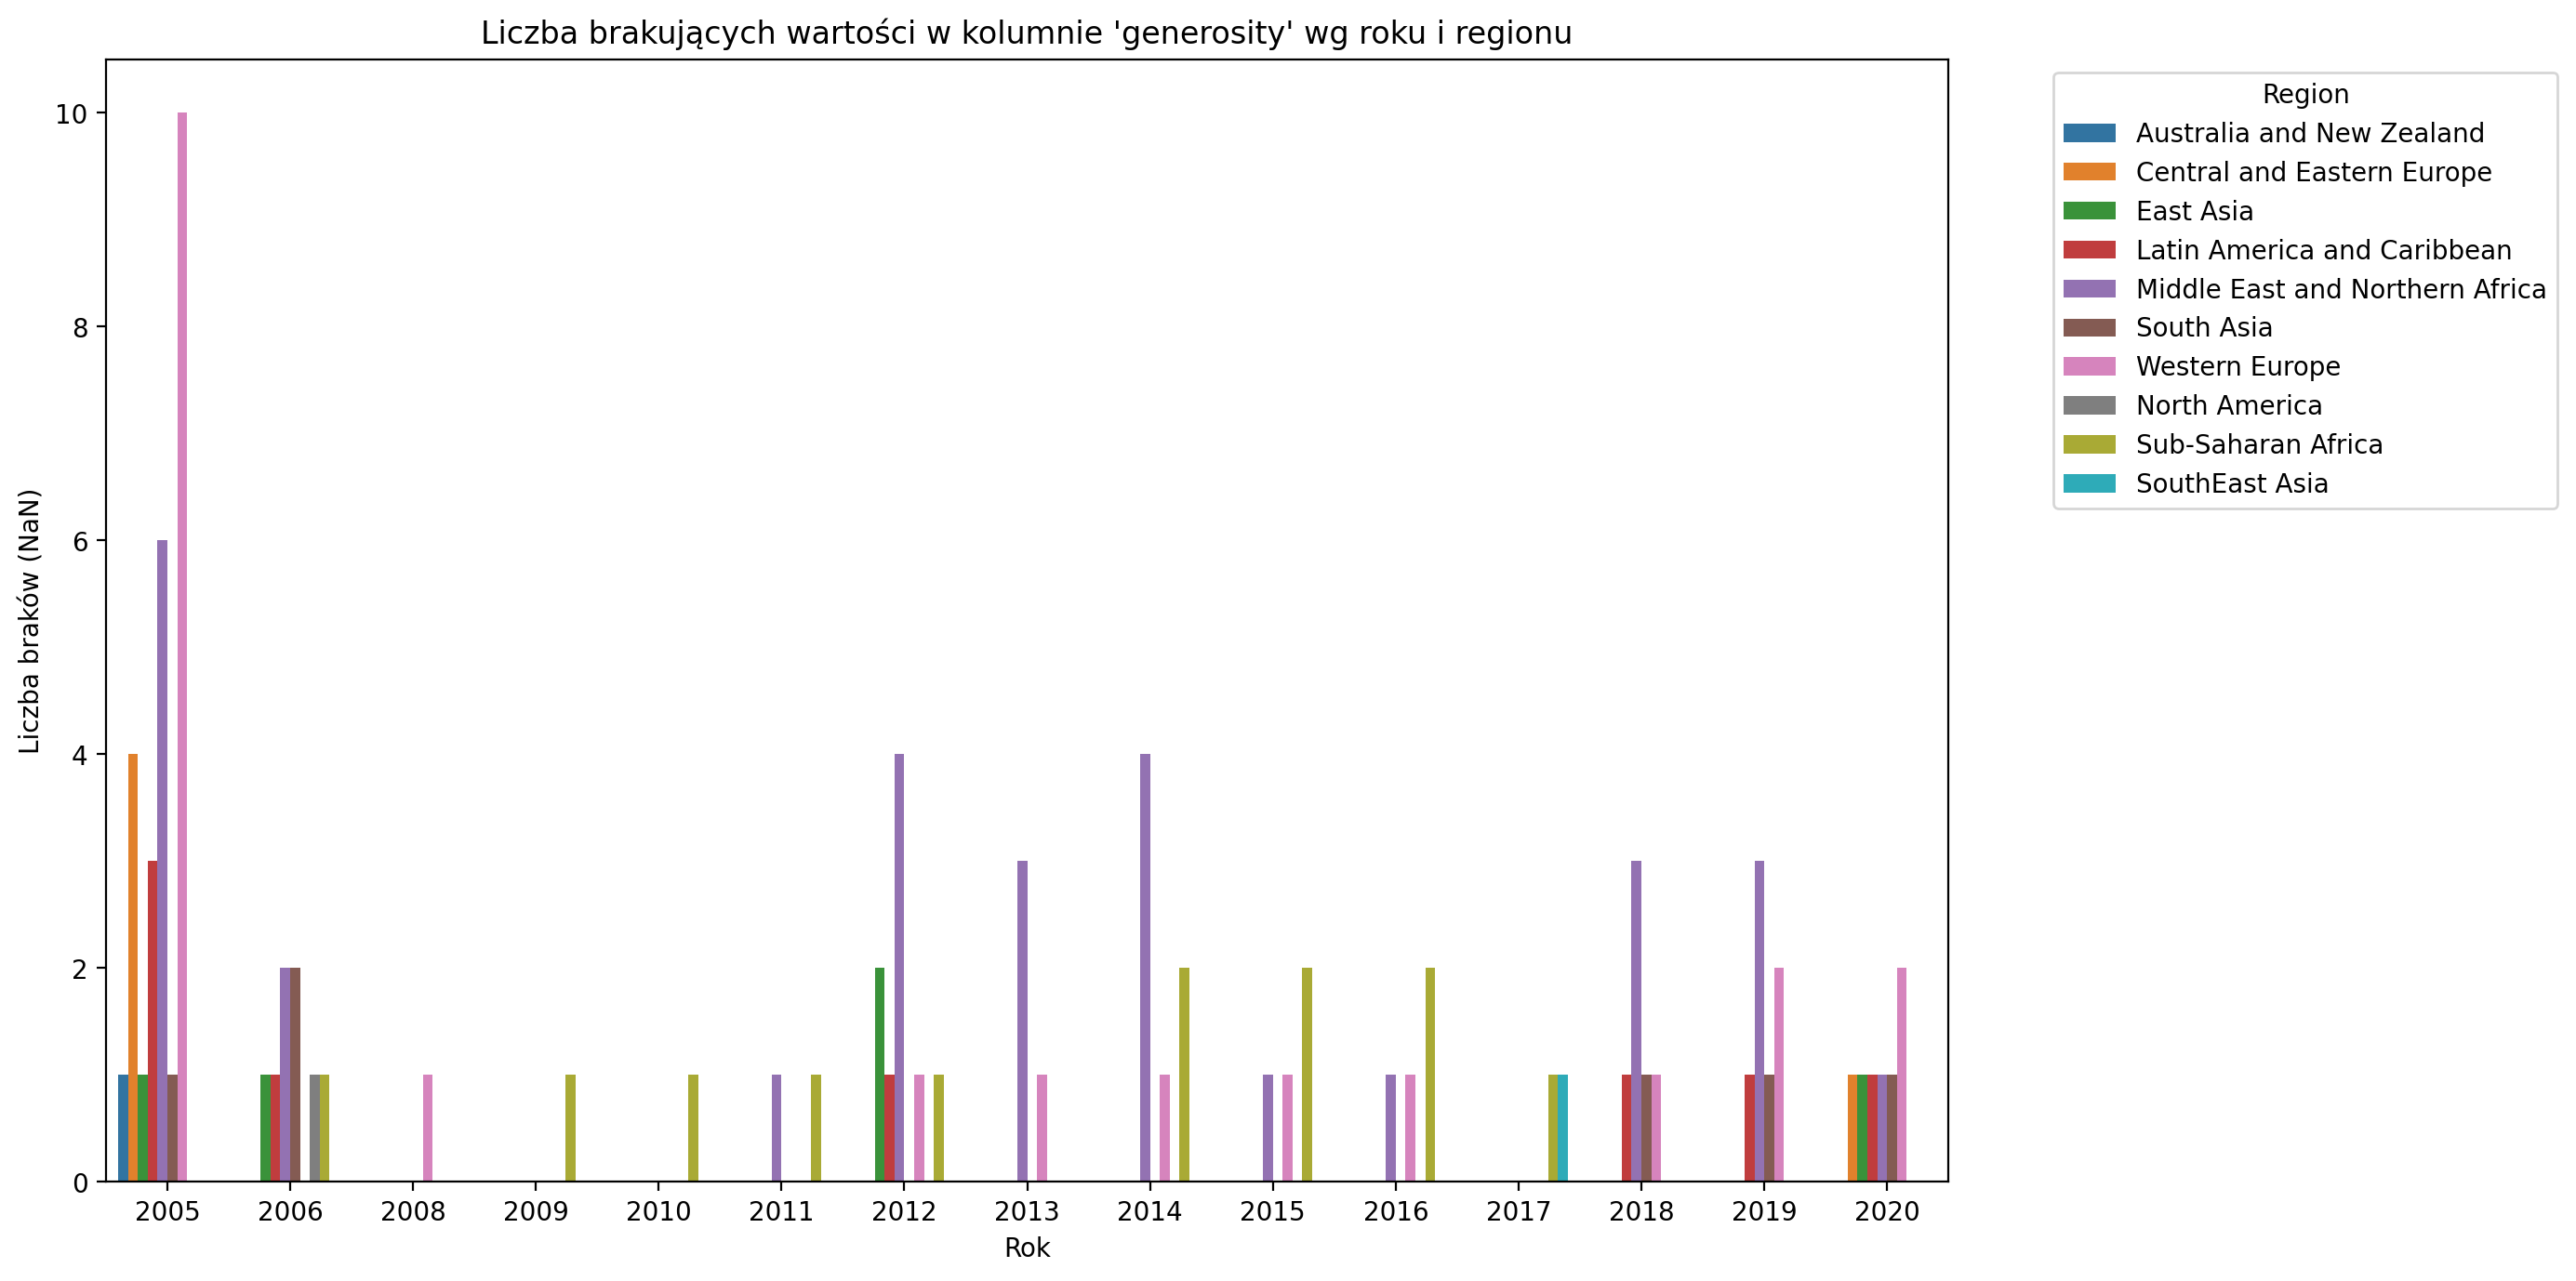

In [164]:
# Filtrowanie tylko obserwacji z brakującą wartością w 'generosity'
missing_ger = df[df['generosity'].isnull()]

# Grupowanie i zliczanie braków według roku i regionu
missing_ger_counts = missing_ger.groupby(['year', 'region']).size().reset_index(name='NaN_count')

# Tworzenie wykresu
plt.figure(figsize=(14, 7))
sns.barplot(data=missing_ger_counts, x='year', y='NaN_count', hue='region')
plt.title("Liczba brakujących wartości w kolumnie 'generosity' wg roku i regionu")
plt.xlabel("Rok")
plt.ylabel("Liczba braków (NaN)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [165]:
# sprawdzenie ile danych jest w 2005 roku w kolumnie 'generosity'
df_2005 = df[df['year'] == 2005]

# Liczenie braków i niebrakujących wartości w kolumnie 'generosity'
generosity_nulls = df_2005['generosity'].isnull().sum()
generosity_filled = df_2005['generosity'].notnull().sum()

# Tworzenie podsumowania
summary_2005 = pd.DataFrame({
    'Missing (NaN)': [generosity_nulls],
    'Filled (Not NaN)': [generosity_filled]
}, index=['generosity'])
summary_2005

,Missing (NaN),Filled (Not NaN)
generosity,26,1


<!-- TODO do edycji? -->
Kolumna *generosity* zawierała najwięcej braków w regionach *Western Europe* i *Middle East and Northern Africa*, a także wiele wystpąpiło w *Central and Eastern Europe* i *Latin America and Caribbean*. W podziale na poszczególne lata najwięcej braków pojawiło się w roku 2005. Natomiast w roku 2005 tylko jedna obserwacja posiadała dane. Dodatkowo aż Zdecydowano przeprowadzić imputację medianą w zależności od regionu.

In [166]:
# imputacja NaN w kolumnie 'generosity' medianą z regionów
df['generosity'] = df.groupby(['region'])['generosity'].transform(
    lambda x: x.fillna(x.median())
)
df['generosity'].isnull().sum()

0

Kolumna *generosity* zawierała najwięcej braków w regionach *Western Europe* i *Middle East and Northern Africa*, a także wiele wystpąpiło w *Central and Eastern Europe* i *Latin America and Caribbean*. Dodatkowo występowały braki wynikające z obecności błędnych (ujemnych) wartości. Braki te początkowo uzupełniono medianą w obrębie regionu i roku, jednak to podejście nie zadziałało dla wszystkich przypadków – w 89 obserwacjach nadal występowały NaN.

Aby poradzić sobie z tym problemem, zastosowano iteracyjną imputację (IterativeImputer), która wykorzystuje inne zmienne (np. social_support, freedom, gdp_per_capita) do oszacowania brakujących danych za pomocą regresji wielorakiej. Metoda ta pozwala uwzględnić ukryte zależności pomiędzy zmiennymi i zmniejsza ryzyko zafałszowania rozkładu danych.

Dzięki takiemu podejściu udało się uzupełnić wszystkie pozostałe braki w generosity, przy zachowaniu spójności z pozostałymi cechami obserwacji.

Kolejno poddano analizie braki w kolumnie *gdp_per_capita*

In [167]:
# braki w 'gdp_per_capita' wg. krajów
df[df['gdp_per_capita'].isnull()]['country'].value_counts().sort_values(ascending=False)

country
North Cyprus                 7
Somaliland region            4
South Sudan                  4
Iran                         3
Somalia                      3
Taiwan Province of China     3
Venezuela                    3
Palestinian Territories      2
Yemen                        2
Cuba                         1
Cyprus                       1
Hong Kong S.A.R. of China    1
Kosovo                       1
Malta                        1
Name: count, dtype: int64

In [168]:
# braki w 'gdp_per_capita' wg. lat
df[df['gdp_per_capita'].isnull()]['year'].value_counts().sort_values(ascending=False)

year
2020    7
2018    6
2019    6
2014    3
2015    3
2016    3
2012    2
2006    1
2013    1
2009    1
2010    1
2011    1
2017    1
Name: count, dtype: int64

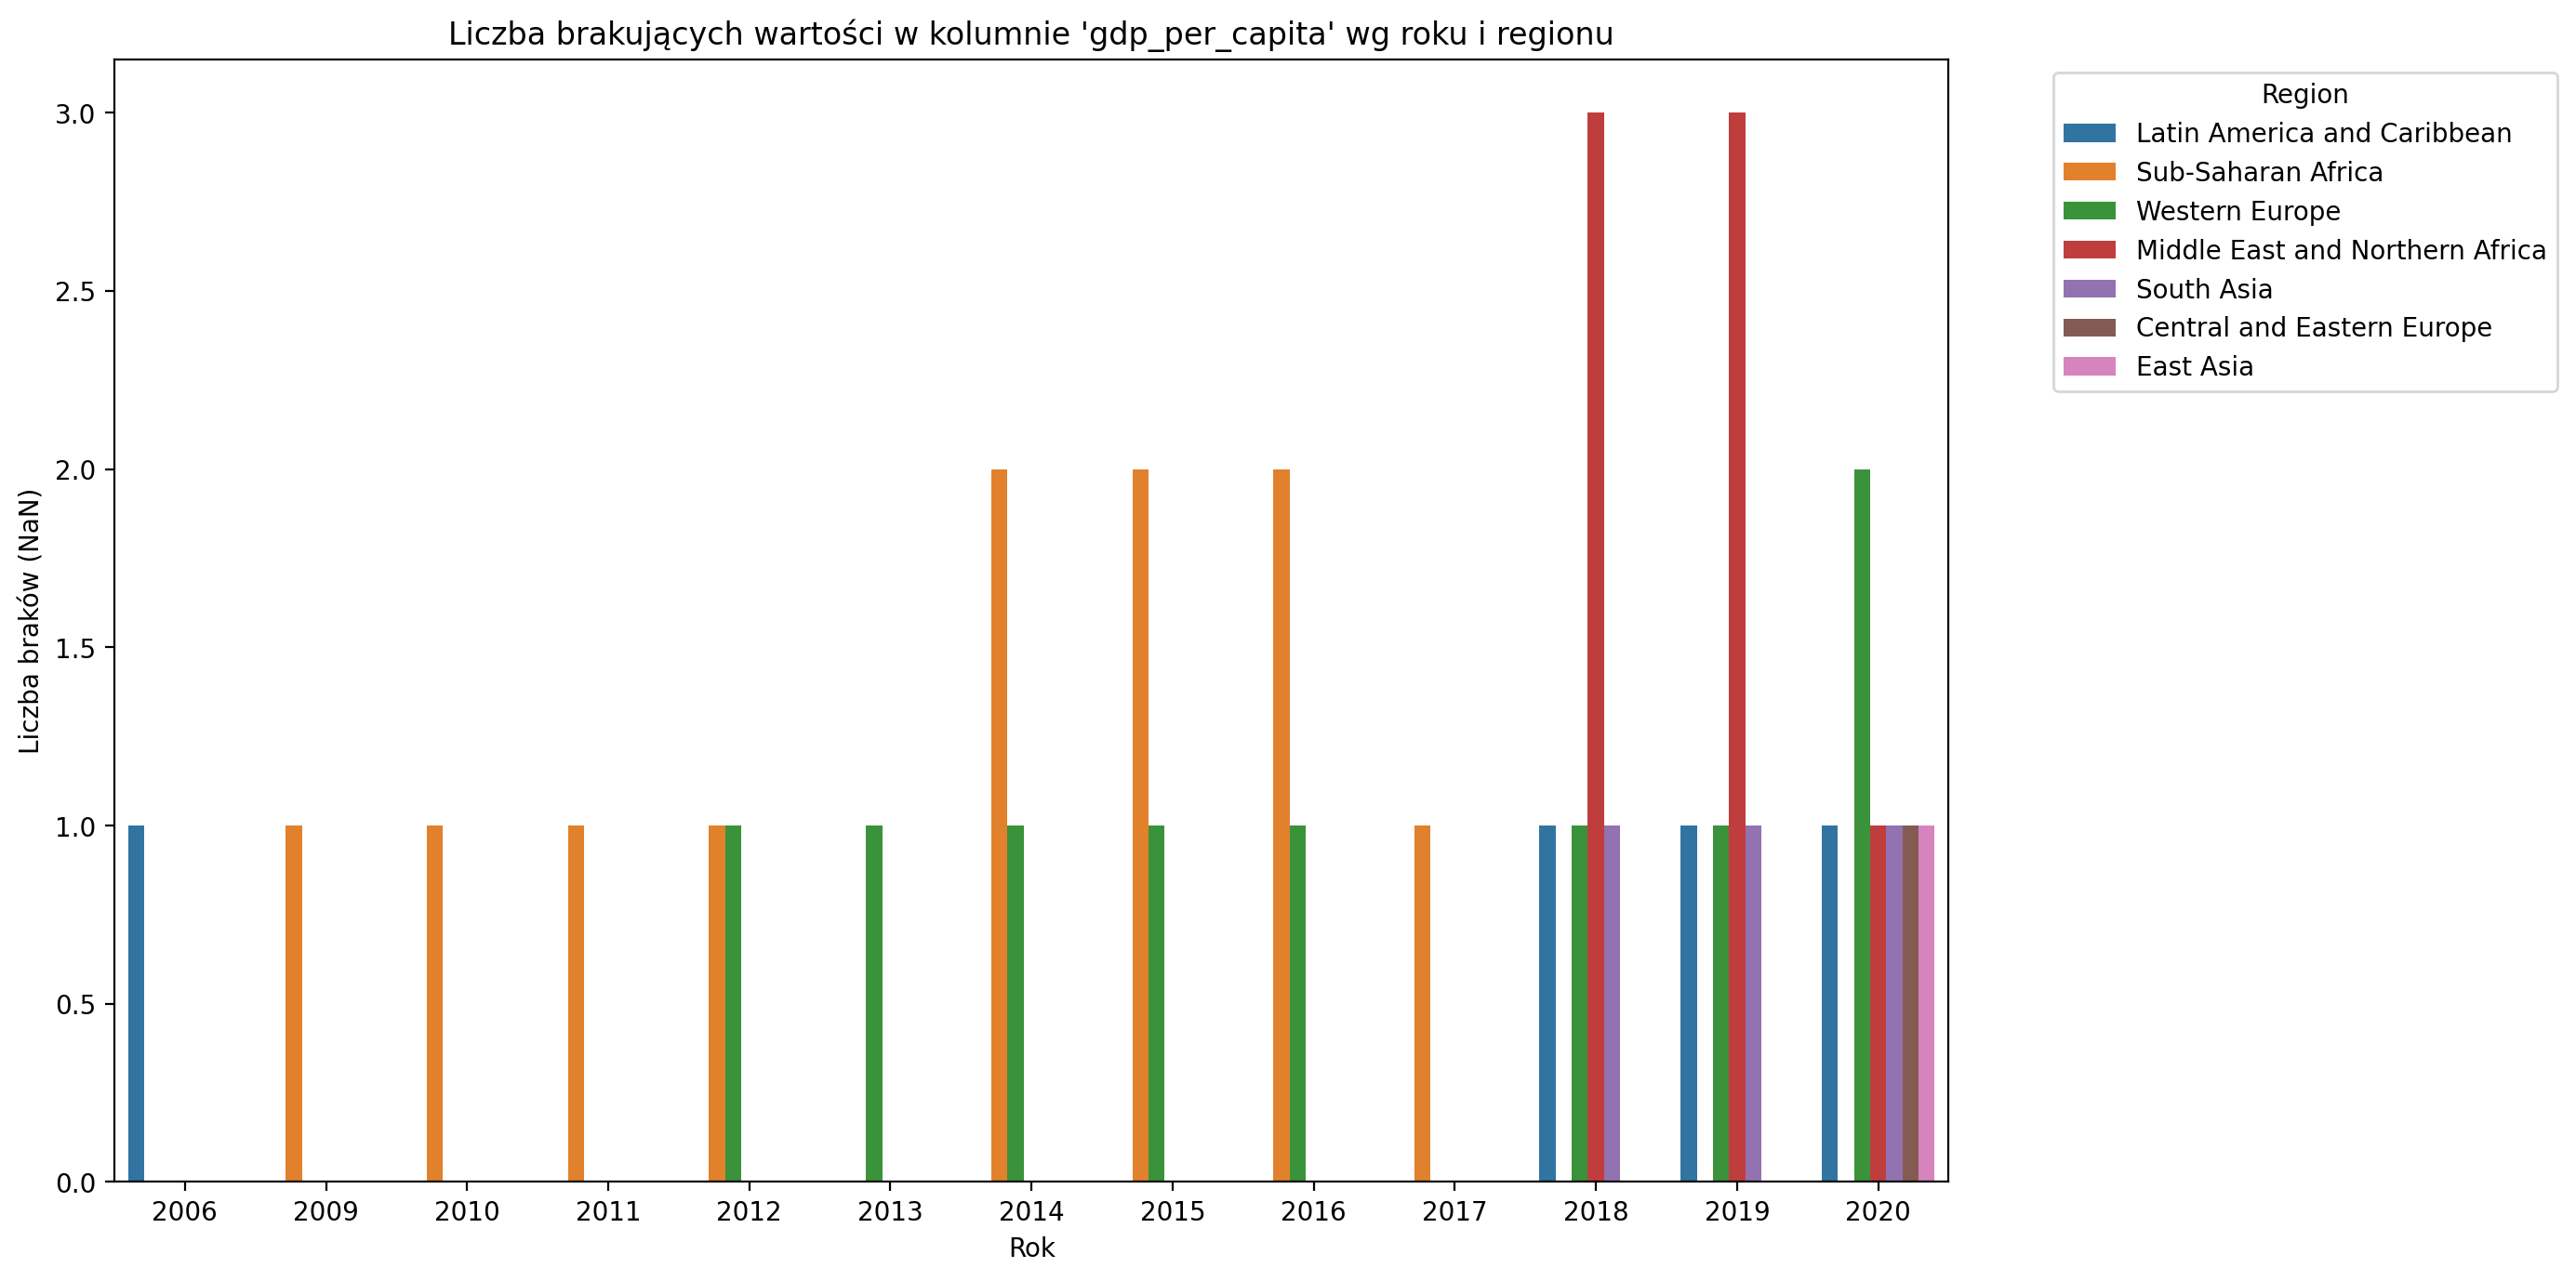

In [169]:
# Filtrowanie tylko obserwacji z brakującą wartością w 'gdp_per_capita'
missing_gdp = df[df['gdp_per_capita'].isnull()]

# Grupowanie i zliczanie braków według roku i regionu
missing_gdp_counts = missing_gdp.groupby(['year', 'region']).size().reset_index(name='NaN_count')

# Tworzenie wykresu
plt.figure(figsize=(14, 7))
sns.barplot(data=missing_gdp_counts, x='year', y='NaN_count', hue='region')
plt.title("Liczba brakujących wartości w kolumnie 'gdp_per_capita' wg roku i regionu")
plt.xlabel("Rok")
plt.ylabel("Liczba braków (NaN)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Imputacja brakujących wartości w kolumnie `gdp_per_capita`

W kolumnie `gdp_per_capita` (PKB per capita) stwierdzono obecność braków danych. Ze względu na charakter tej zmiennej — makroekonomicznej i odnoszącej się do konkretnego kraju i roku — wartości te powinny być identyczne dla wszystkich obserwacji odpowiadających danemu krajowi w danym roku.

Przeprowadzono analizę rozkładu braków względem lat i regionów. Występowanie braków było nierównomierne, co wyklucza przypadkowość (MCAR). Braki występowały częściej w mniej rozwiniętych regionach i w starszych rocznikach, co może wskazywać na mechanizm MAR (ang. *Missing At Random*).

Aby zachować spójność danych i nie zniekształcać rozkładu PKB w analizie, zastosowano **wielopoziomową strategię imputacji**:

1. W pierwszej kolejności uzupełniono braki medianą `gdp_per_capita` dla danego kraju i roku.
2. Jeśli brakowało danych dla konkretnego roku, wykorzystano średnią `gdp_per_capita` danego kraju z roku następnego i poprzedniego.
3. W kolejnym kroku wartość wyestymowano przy użyciu regresji liniowej na podstawie `gdp_per_capita` kraju w innych latach. 
4. W ostateczności, jeżeli kraj nie miał żadnych danych w innych latach, zastosowano medianę dla regionu i roku.

Taka strategia pozwala na uzupełnienie wszystkich braków w sposób maksymalnie dopasowany do kontekstu geograficzno-czasowego, a jednocześnie ogranicza ryzyko wprowadzenia zniekształceń do dalszej analizy.


In [170]:
# Kopia ramki danych
df_filled = df.copy()

# 1. Mediana dla country + year
gdp_country_year = df.groupby(['country', 'year'])['gdp_per_capita'].median()

# 2. Średnia z roku poprzedniego i następnego
def interpolate_gdp(row):
    country = row['country']
    year = row['year']
    
    prev_val = gdp_country_year.get((country, year - 1), np.nan)
    next_val = gdp_country_year.get((country, year + 1), np.nan)
    
    if not pd.isna(prev_val) and not pd.isna(next_val):
        return (prev_val + next_val) / 2
    return np.nan

# 3. Estymacja na podstawie trendu liniowego dla kraju
def estimate_from_trend(row):
    country = row['country']
    year = row['year']
    
    country_data = df[~df['gdp_per_capita'].isnull() & (df['country'] == country)]
    if country_data.empty or len(country_data['year'].unique()) < 2:
        return np.nan
    
    x = country_data['year']
    y = country_data['gdp_per_capita']
    a, b = np.polyfit(x, y, deg=1)
    return a * year + b

# 4. Mediana dla regionu + year
gdp_region_year = df.groupby(['region', 'year'])['gdp_per_capita'].median()

# Krok 1
mask = df_filled['gdp_per_capita'].isnull()
df_filled.loc[mask, 'gdp_per_capita'] = df_filled.loc[mask].apply(
    lambda row: gdp_country_year.get((row['country'], row['year']), np.nan),
    axis=1
)

# Krok 2
mask = df_filled['gdp_per_capita'].isnull()
df_filled.loc[mask, 'gdp_per_capita'] = df_filled.loc[mask].apply(interpolate_gdp, axis=1)

# Krok 3
mask = df_filled['gdp_per_capita'].isnull()
df_filled.loc[mask, 'gdp_per_capita'] = df_filled.loc[mask].apply(estimate_from_trend, axis=1)

# Krok 4
mask = df_filled['gdp_per_capita'].isnull()
df_filled.loc[mask, 'gdp_per_capita'] = df_filled.loc[mask].apply(
    lambda row: gdp_region_year.get((row['region'], row['year']), np.nan),
    axis=1
)

# Przypisanie uzupełnionej kolumny do oryginalnego dataframe
df['gdp_per_capita'] = df_filled['gdp_per_capita']

# Sprawdzenie końcowej liczby braków w df
df['gdp_per_capita'].isnull().sum()

0

<!-- TODO napisać -->
następna *social_support*

In [171]:
# braki w 'social_support' wg. krajów
df[df['social_support'].isnull()]['region'].value_counts().sort_values(ascending=False)

region
Middle East and Northern Africa    9
North America                      2
Sub-Saharan Africa                 1
SouthEast Asia                     1
Name: count, dtype: int64

In [172]:
# braki w 'social_support' wg. lat
df[df['social_support'].isnull()]['year'].value_counts().sort_values(ascending=False)

year
2010    4
2014    3
2007    2
2011    1
2015    1
2009    1
2017    1
Name: count, dtype: int64

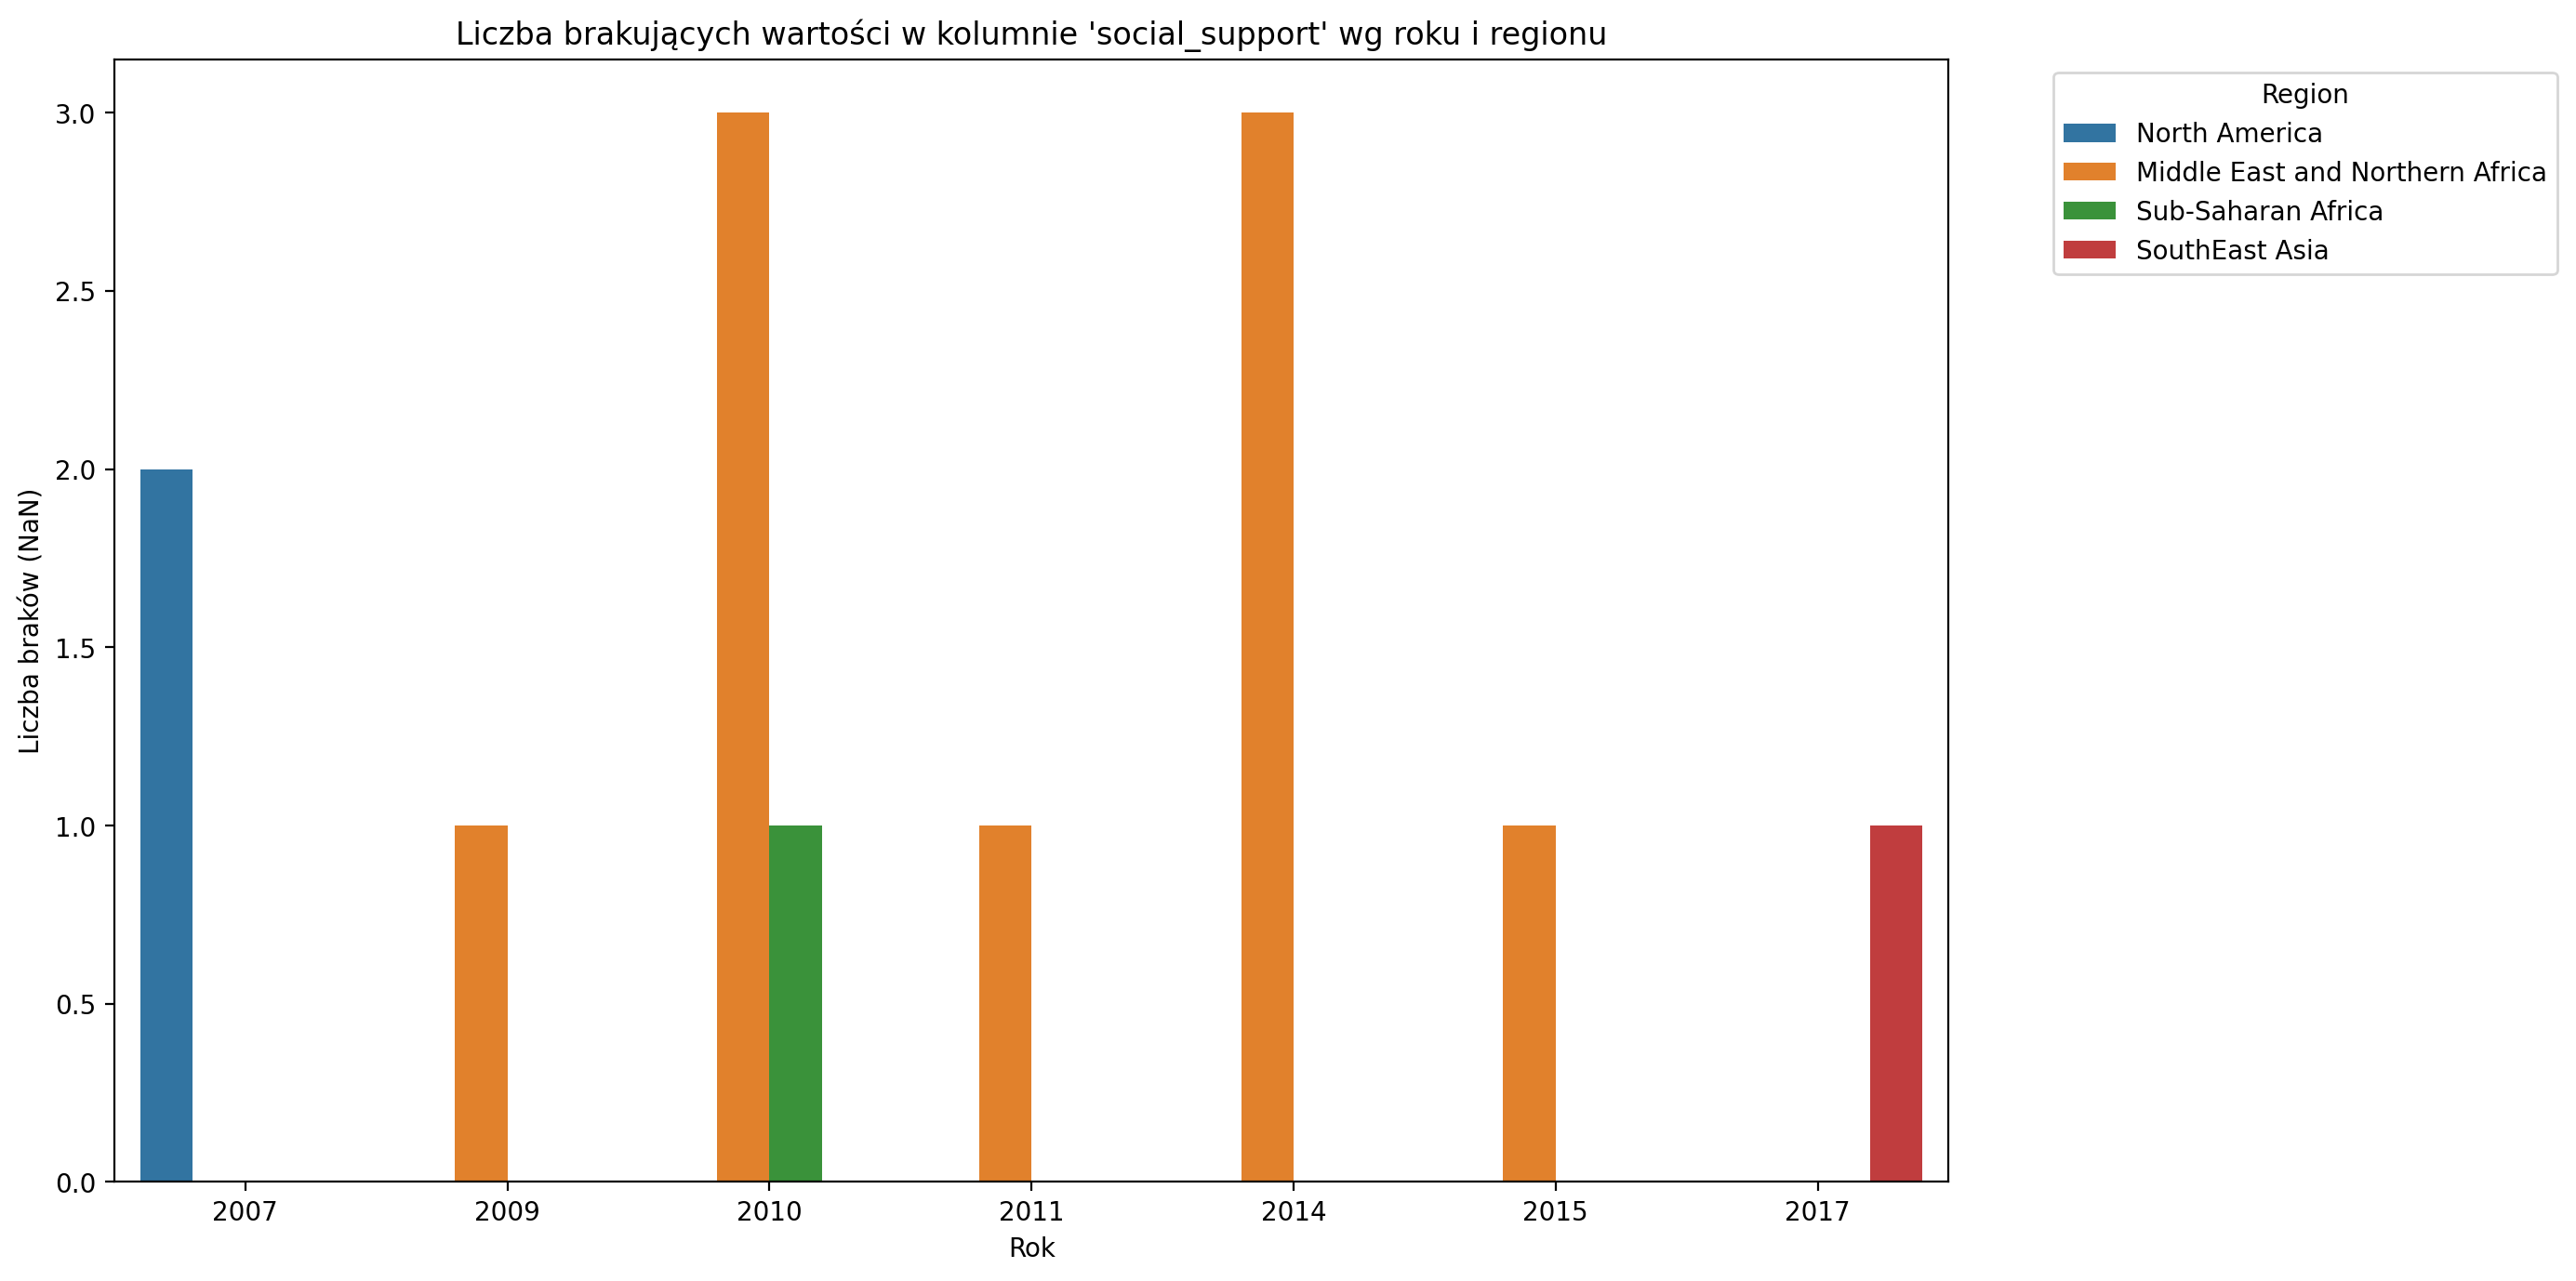

In [173]:
# Filtrowanie tylko obserwacji z brakującą wartością w 'gdp_per_capita'
missing_soc = df[df['social_support'].isnull()]

# Grupowanie i zliczanie braków według roku i regionu
missing_soc_counts = missing_soc.groupby(['year', 'region']).size().reset_index(name='NaN_count')

# Tworzenie wykresu
plt.figure(figsize=(14, 7))
sns.barplot(data=missing_soc_counts, x='year', y='NaN_count', hue='region')
plt.title("Liczba brakujących wartości w kolumnie 'social_support' wg roku i regionu")
plt.xlabel("Rok")
plt.ylabel("Liczba braków (NaN)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<!-- TODO napisać -->
*social_support* lata równomiernie, region się wybija Middle East and Northern Africa

In [174]:
# imputacja NaN w kolumnie 'generosity' medianą z regionów
df['social_support'] = df.groupby(['region'])['social_support'].transform(
    lambda x: x.fillna(x.median())
)
df['social_support'].isnull().sum()

0

In [175]:
# do testów

# Zliczanie braków w każdej kolumnie, pogrupowane po roku i regionie
missing_summary = df.groupby(['year', 'region']).apply(lambda x: x.isnull().sum().sum()).reset_index(name='total_missing')

missing_summary[missing_summary['year']==2005].sort_values(by='total_missing', ascending=False)

,year,region,total_missing
0,2005,Australia and New Zealand,0
1,2005,Central and Eastern Europe,0
2,2005,East Asia,0
3,2005,Latin America and Caribbean,0
4,2005,Middle East and Northern Africa,0
5,2005,North America,0
6,2005,South Asia,0
7,2005,Western Europe,0


In [176]:
# do testów - wywalenia
# wszystkie braki sumarycznie dla poszczególnych krajów
df[df.isnull().any(axis=1)]['country'].value_counts()
missing_by_country = df.groupby('country').apply(lambda x: x.isnull().sum().sum()).sort_values(ascending=False)
print(missing_by_country.head(10))

country
Afghanistan        0
Netherlands        0
Nicaragua          0
Niger              0
Nigeria            0
North Cyprus       0
North Macedonia    0
Norway             0
Oman               0
Pakistan           0
dtype: int64


In [177]:
# zapisuje oczyszczony DataFrame do pliku CSV
df_cleaned = df
df_cleaned.to_csv('../data/happiness_cleaned.csv', index=False)

In [178]:
# do wywalenia
# do savowania danych
# df_cleaned = df
# df_cleaned.to_csv('../data/happiness_cleaned.csv', index=False)
# df_cleaned.isnull().sum()

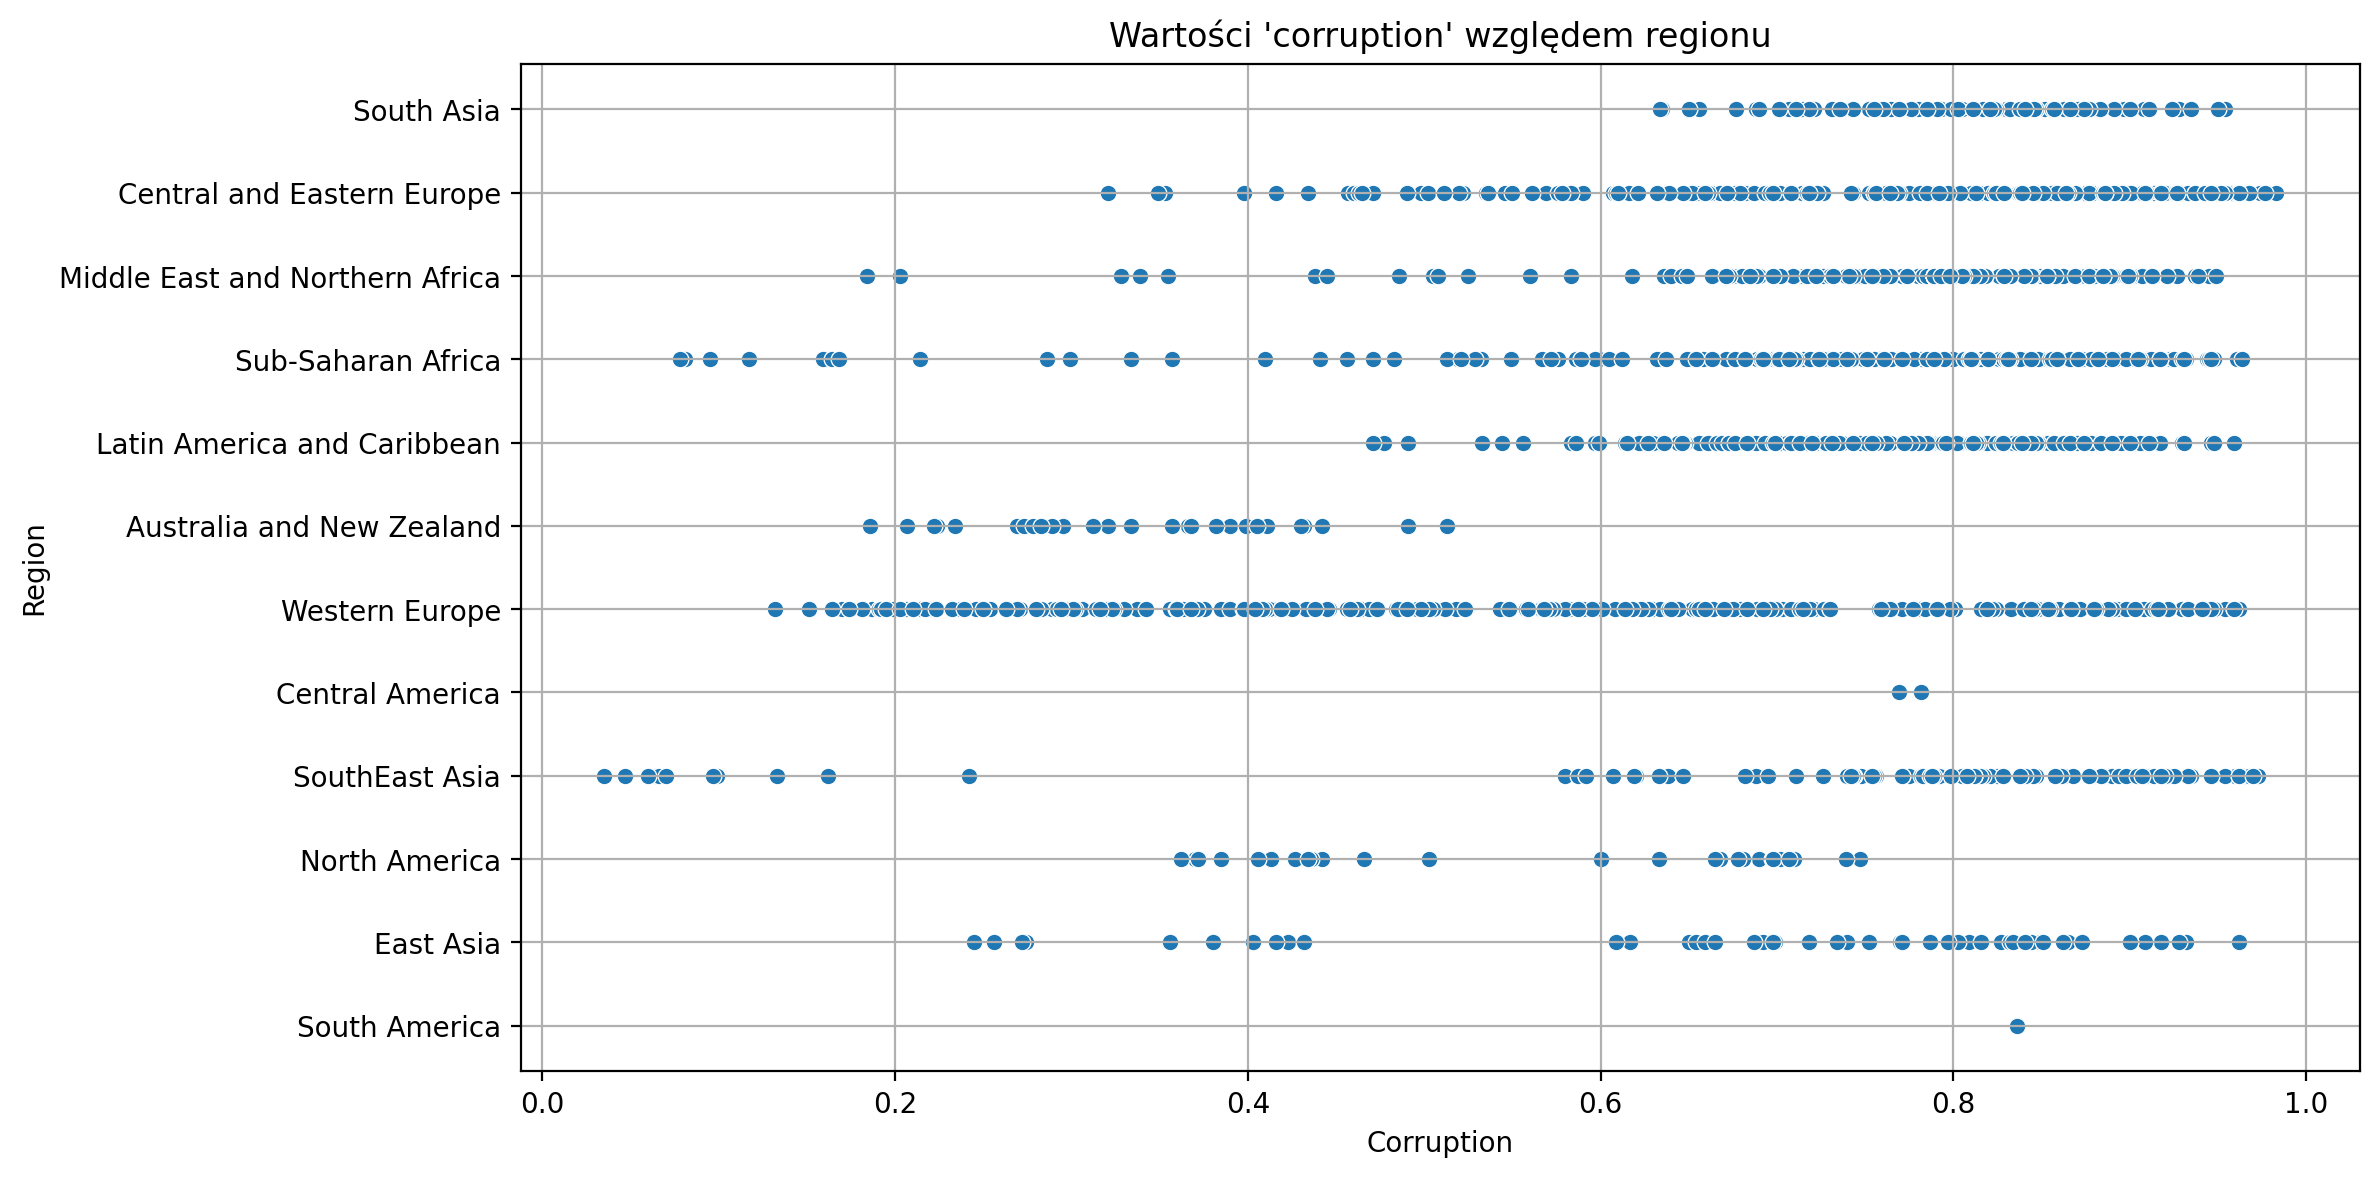

In [135]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='corruption', y='region')
plt.title("Wartości 'corruption' względem regionu")
plt.xlabel("Corruption")
plt.ylabel("Region")
plt.grid(True)
plt.tight_layout()
plt.show()